In [ ]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
if tf.config.list_physical_devices('GPU'):
    print(tf.config.list_physical_devices('GPU'))
else:
    print("TensorFlow GPU not found!")

TensorFlow GPU not found!


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
%%time
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0], shape=[3], name='a')
    b = tf.constant([1.0, 2.0, 3.0], shape=[3], name='b')
    c = tf.add(a, b)

print(c)
#вычисления проходят на CPU, т к если tf не находит GPU, то автоматически переходит на проссор

tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32)
CPU times: total: 15.6 ms
Wall time: 56.8 ms


In [ ]:
if tf.config.list_physical_devices('CPU'):
    print(tf.config.list_physical_devices('CPU'))
else:
    print("TensorFlow СPU not found!")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
%%time
with tf.device('/CPU:0'):
    a = tf.constant([1.0, 2.0, 3.0], shape=[3], name='a')
    b = tf.constant([1.0, 2.0, 3.0], shape=[3], name='b')
    c = tf.add(a, b)

print(c)

tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32)
CPU times: total: 0 ns
Wall time: 994 μs


**Подготовка данных**

In [ ]:
# Загрузка CIFAR-10 датасета
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [ ]:
# Нормализация изображений
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Преобразование меток в one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
train_images.shape

(50000, 32, 32, 3)

In [ ]:
train_labels.shape, test_labels.shape,

((50000, 10), (10000, 10))

In [ ]:
# Создание объекта ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Выполнение аугментации данных с использованием datagen
datagen.fit(train_images)

# Пример использования .flow() для обучения модели
# model.fit(datagen.flow(train_images, train_labels, batch_size=32), steps_per_epoch=len(train_images) / 32, epochs=10)

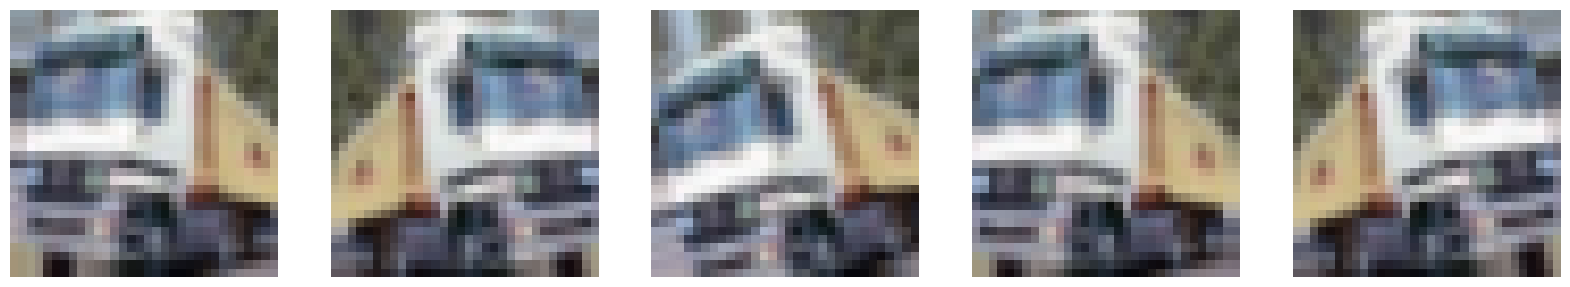

In [ ]:
# Генерация аугментированных изображений
augmented_images = [train_images[1] for i in range(5)]
augmented_images = np.array(augmented_images)
augmented_images = datagen.flow(augmented_images, batch_size=5, shuffle=False).__next__()

# Визуализация изображений
fig, axarr = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    axarr[i].imshow(augmented_images[i])
    axarr[i].axis('off')

plt.show()


In [ ]:
test_images.shape

(10000, 32, 32, 3)

**Подготовка нептуны**

In [ ]:
import neptune


In [ ]:
from keras.callbacks import Callback

class NeptuneLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        for name, value in logs.items():
            run[f"metrics/{name}"].log(value)

# **Работа с собственным генератором**

In [ ]:
#Собственный
def custom_generator(X, y, batch_size):
    while True:

        rotation_range = np.random.choice([5, 10, 15, 20, 25, 30, 35])
        width_shift_range = np.random.choice([0.1, 0.2, 0.3, 0.4])
        height_shift_range = np.random.choice([0.1, 0.2, 0.3, 0.4])

        datagen = ImageDataGenerator(
            rotation_range=rotation_range,
            width_shift_range=width_shift_range,
            height_shift_range=height_shift_range,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        for batch in datagen.flow(X, y, batch_size=batch_size):
            yield batch

In [ ]:
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input


neptune_logger = NeptuneLogger()

run = neptune.init_run(
    project="vladislavermakovich/HW33",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)

model = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), padding = "same",
           activation='relu',
           strides = 2),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(custom_generator(train_images, train_labels, batch_size=32),
          steps_per_epoch=int(len(train_images) / 32),
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[neptune_logger])

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/HW33/e/HW1-5
Epoch 1/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.2382 - loss: 2.0272 - val_accuracy: 0.3832 - val_loss: 1.6921
Epoch 2/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.3704 - loss: 1.7169 - val_accuracy: 0.4486 - val_loss: 1.4968
Epoch 3/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4078 - loss: 1.6141 - val_accuracy: 0.4551 - val_loss: 1.4744
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4331 - loss: 1.5489 - val_accuracy: 0.4815 - val_loss: 1.3947
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4529 - loss: 1.5012 - val_accuracy: 0.5187 - val_loss: 1.3175
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.4634 - loss: 1.4659 - val_accuracy: 0.5132 - val_loss: 1.3710
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4808 - loss: 1.4363 - va

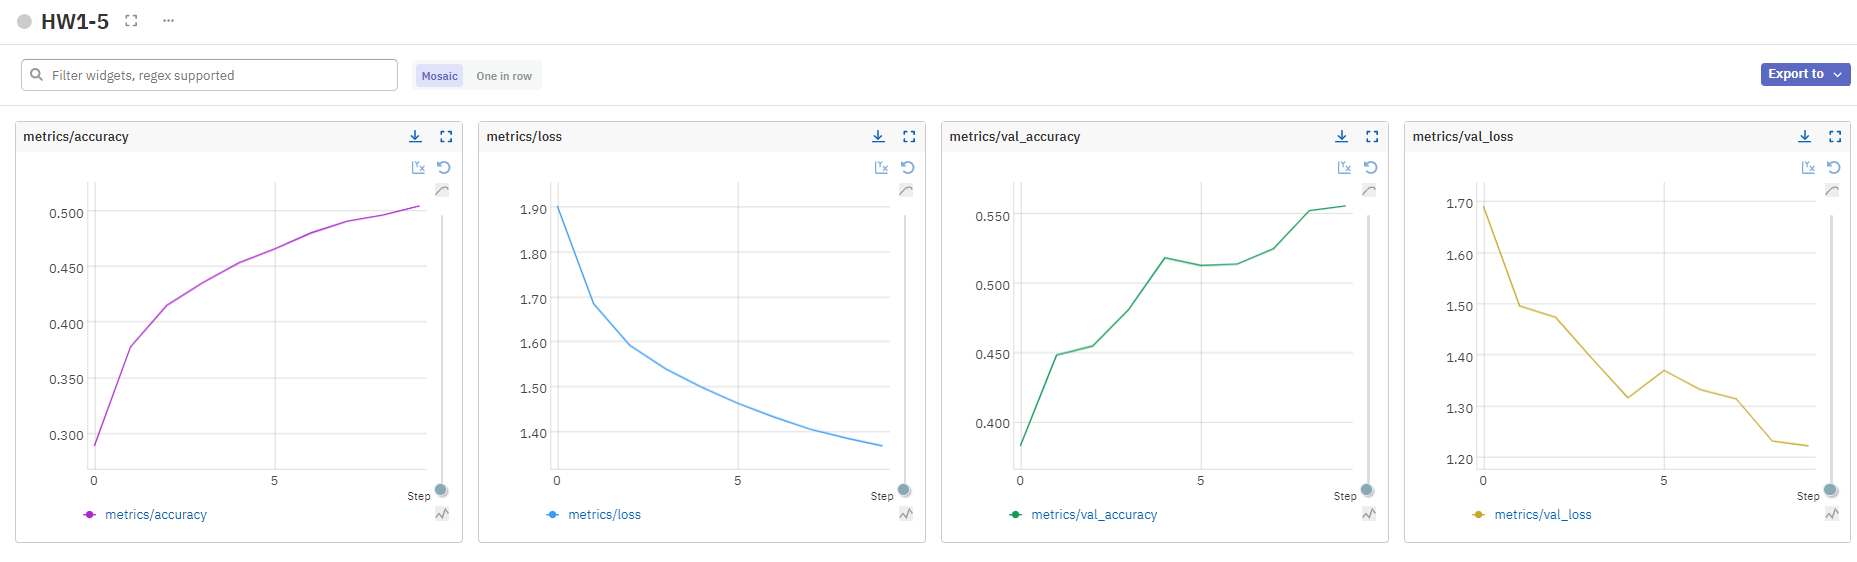

In [ ]:
import keras

neptune_logger = NeptuneLogger()

run = neptune.init_run(
    project="vladislavermakovich/HW33",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)

inputs = keras.Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), padding="same", activation='relu', strides=2)(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(custom_generator(train_images, train_labels, batch_size=32),
          steps_per_epoch=int(len(train_images) / 32),
          epochs=10,
          validation_data=(test_images, test_labels),
         callbacks=[neptune_logger])


run.stop()


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/HW33/e/HW1-6
Epoch 1/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.2575 - loss: 1.9734 - val_accuracy: 0.4416 - val_loss: 1.4873
Epoch 2/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.3978 - loss: 1.6431 - val_accuracy: 0.4587 - val_loss: 1.5015
Epoch 3/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4376 - loss: 1.5381 - val_accuracy: 0.4859 - val_loss: 1.4364
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4618 - loss: 1.4732 - val_accuracy: 0.5257 - val_loss: 1.3082
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4893 - loss: 1.4205 - val_accuracy: 0.5277 - val_loss: 1.3051
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.4966 - loss: 1.3929 - val_accuracy: 0.5489 - val_loss: 1.2522
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5145 - loss: 1.3613 - va

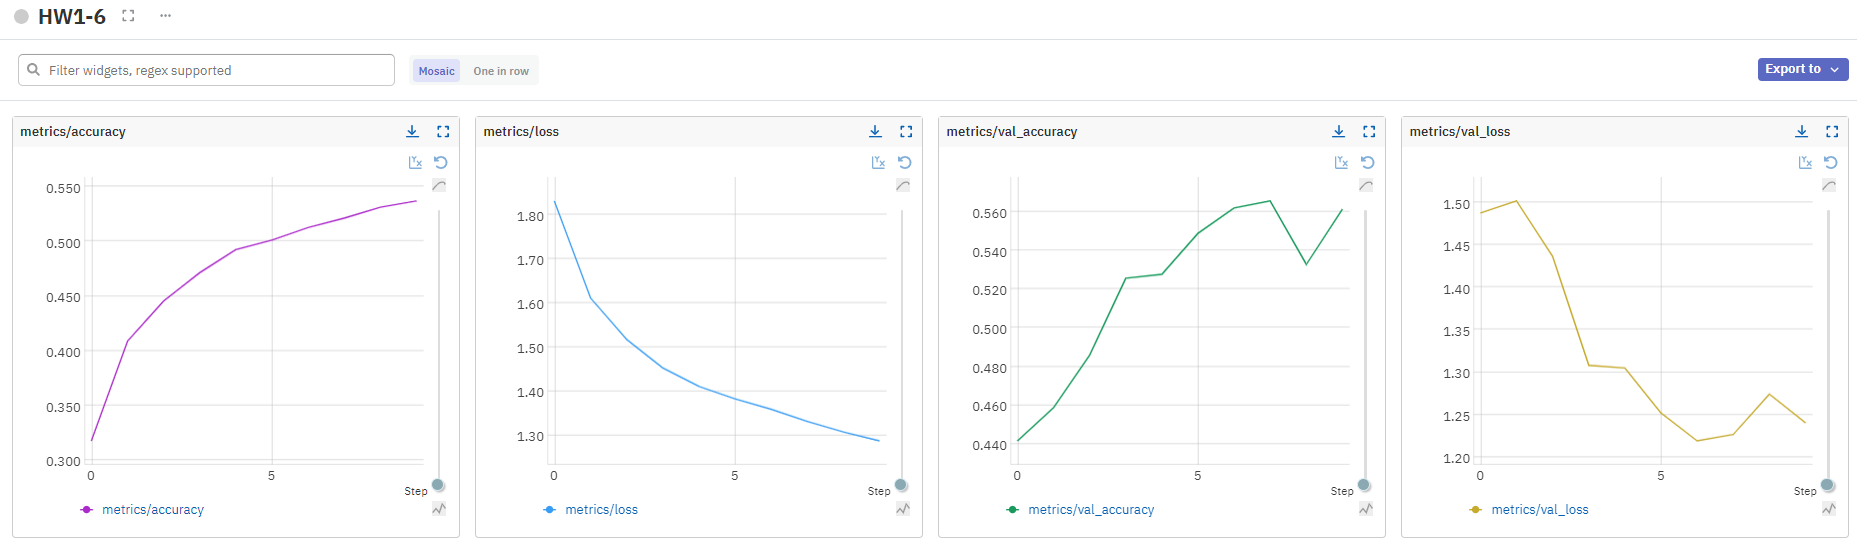

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


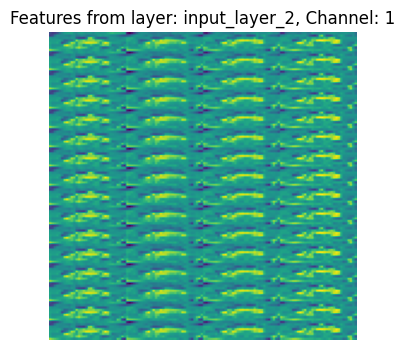

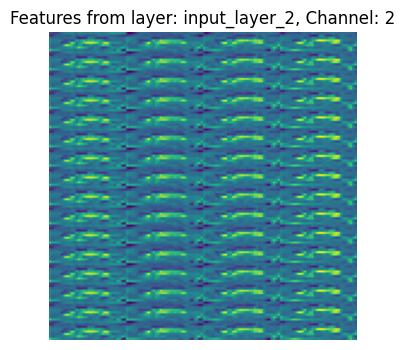

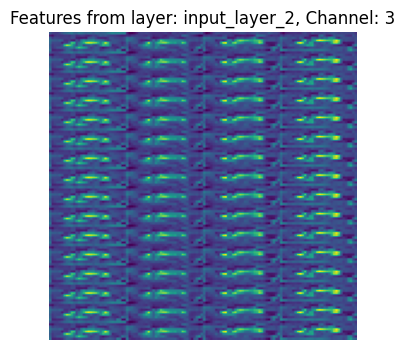

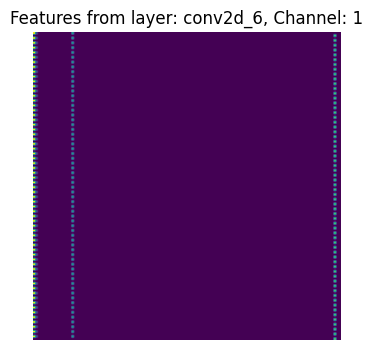

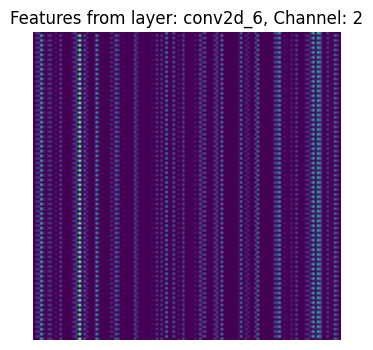

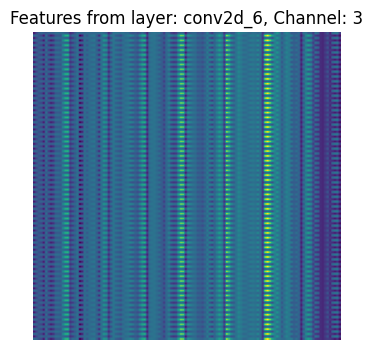

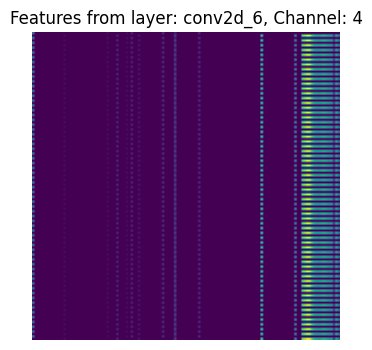

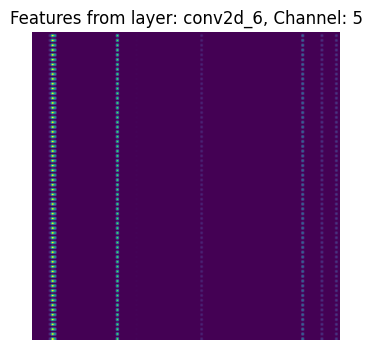

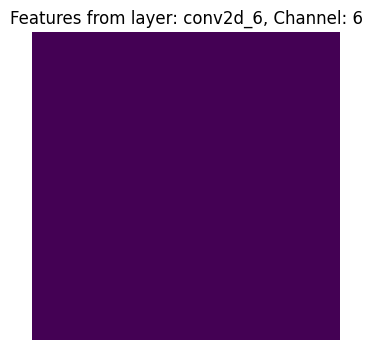

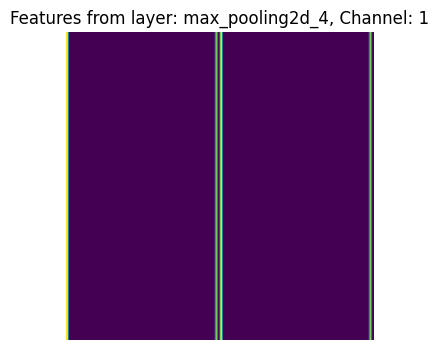

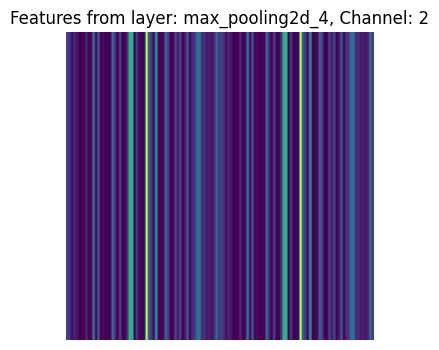

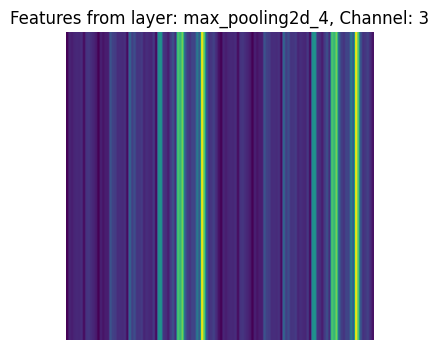

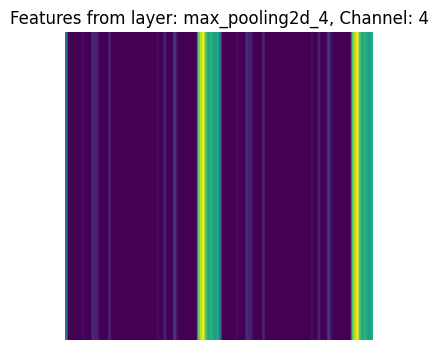

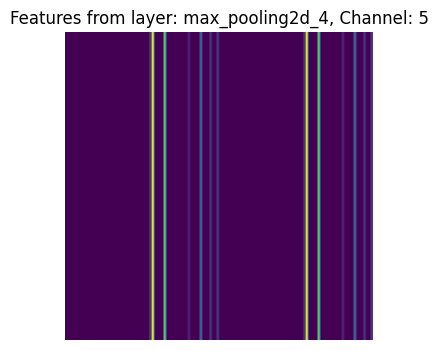

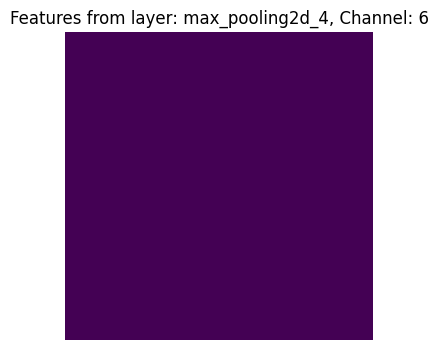

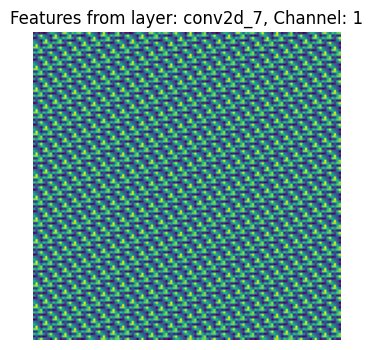

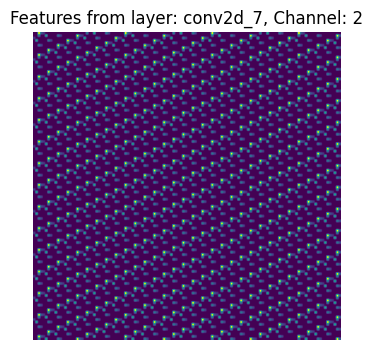

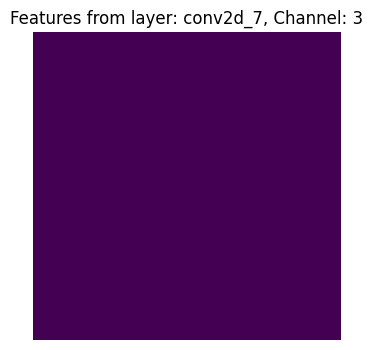

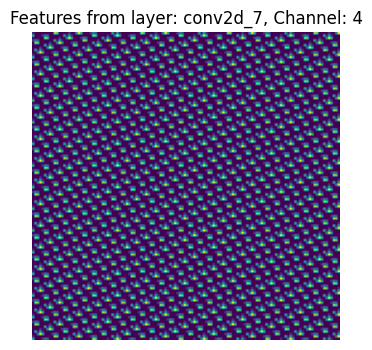

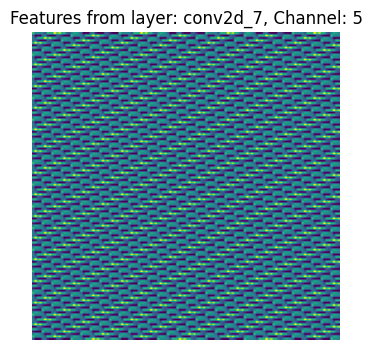

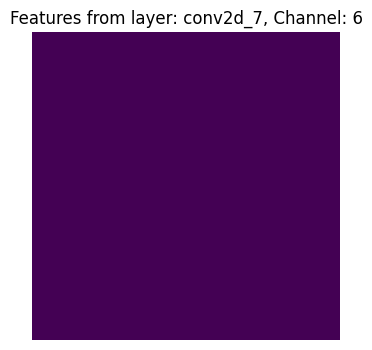

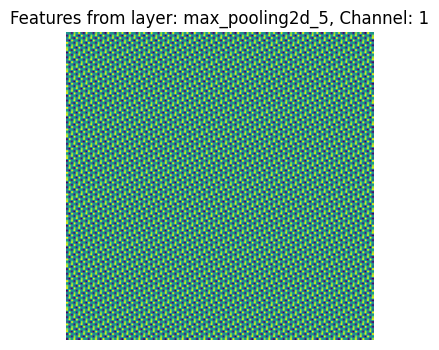

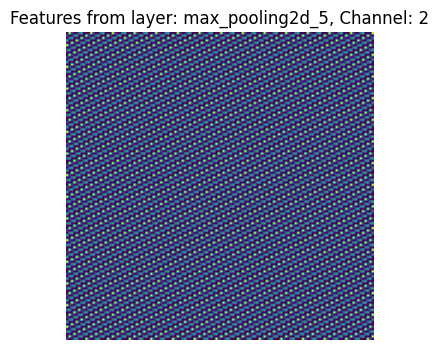

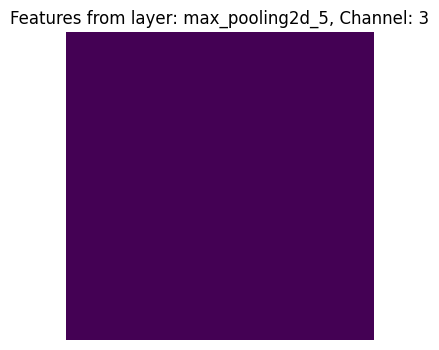

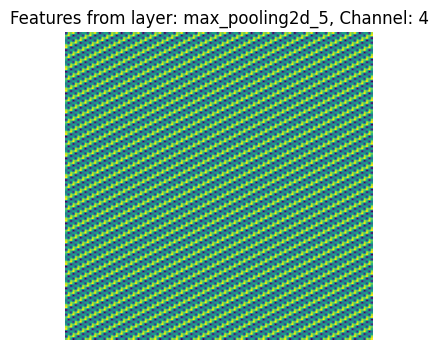

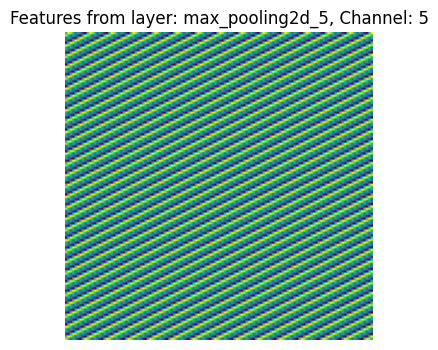

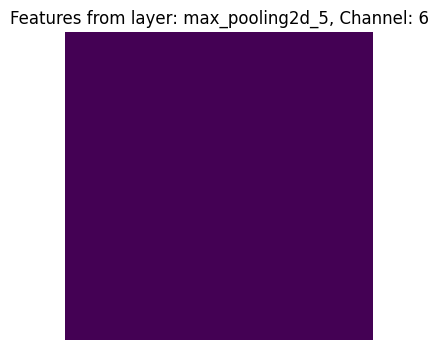

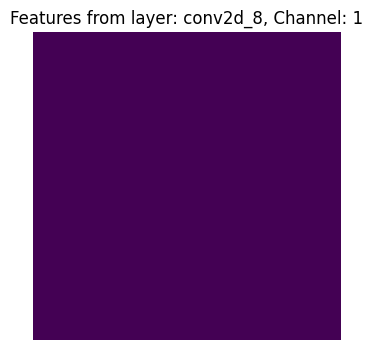

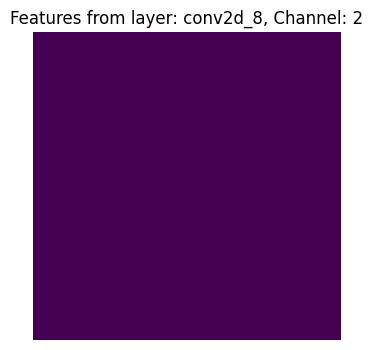

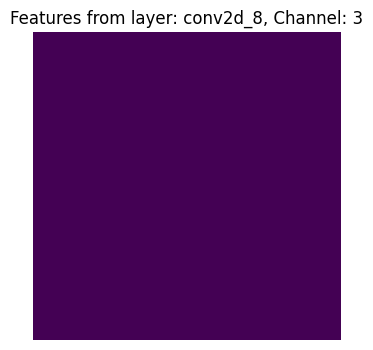

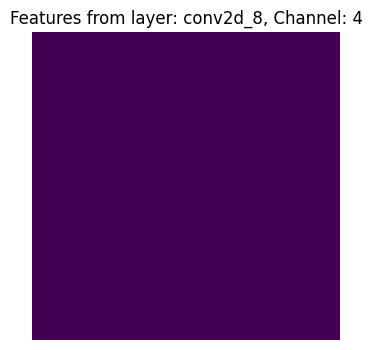

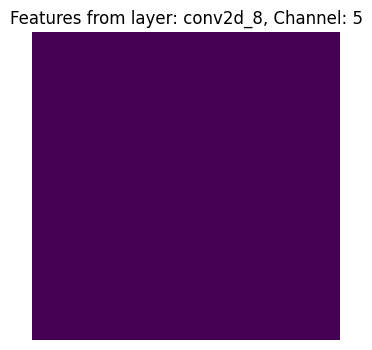

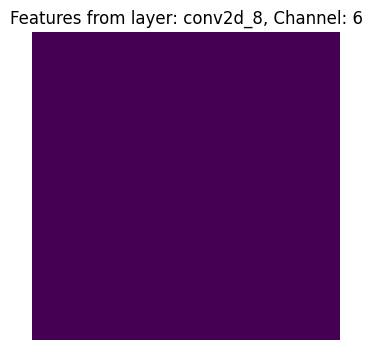

In [ ]:
img = train_images[0]
img = np.expand_dims(img, axis=0)

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img)


def upscale_to_128x128(img):
    return np.resize(img, (128, 128))


for layer_name, layer_activation in zip([layer.name for layer in model.layers], activations):

    if len(layer_activation.shape) == 4:

        for i in range(min(6, layer_activation.shape[-1])):
            plt.figure(figsize=(16, 4))
            channel_image = layer_activation[0, :, :, i]
            channel_image = upscale_to_128x128(channel_image)
            plt.imshow(channel_image, cmap='viridis')
            plt.title(f"Features from layer: {layer_name}, Channel: {i+1}")
            plt.axis('off')
            plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping

neptune_logger = NeptuneLogger()

run = neptune.init_run(
    project="vladislavermakovich/HW33",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)


model = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)


model.fit(custom_generator(train_images, train_labels, batch_size=32),
          steps_per_epoch=int(len(train_images) / 32),
          epochs=30,
          validation_data=(test_images, test_labels),
          callbacks=[neptune_logger, early_stopping])

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/HW33/e/HW1-8
Epoch 1/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.2496 - loss: 1.9983 - val_accuracy: 0.4526 - val_loss: 1.5158
Epoch 2/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.3915 - loss: 1.6522 - val_accuracy: 0.4598 - val_loss: 1.5101
Epoch 3/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.4431 - loss: 1.5278 - val_accuracy: 0.5498 - val_loss: 1.2781
Epoch 4/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.4717 - loss: 1.4531 - val_accuracy: 0.5105 - val_loss: 1.3822
Epoch 5/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.5013 - loss: 1.3889 - val_accuracy: 0.5646 - val_loss: 1.2303
Epoch 6/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.5100 - loss: 1.3617 - val_accuracy: 0.5735 - val_loss: 1.1961
Epoch 7/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.5268 - loss: 1.3238 - va

0.6551

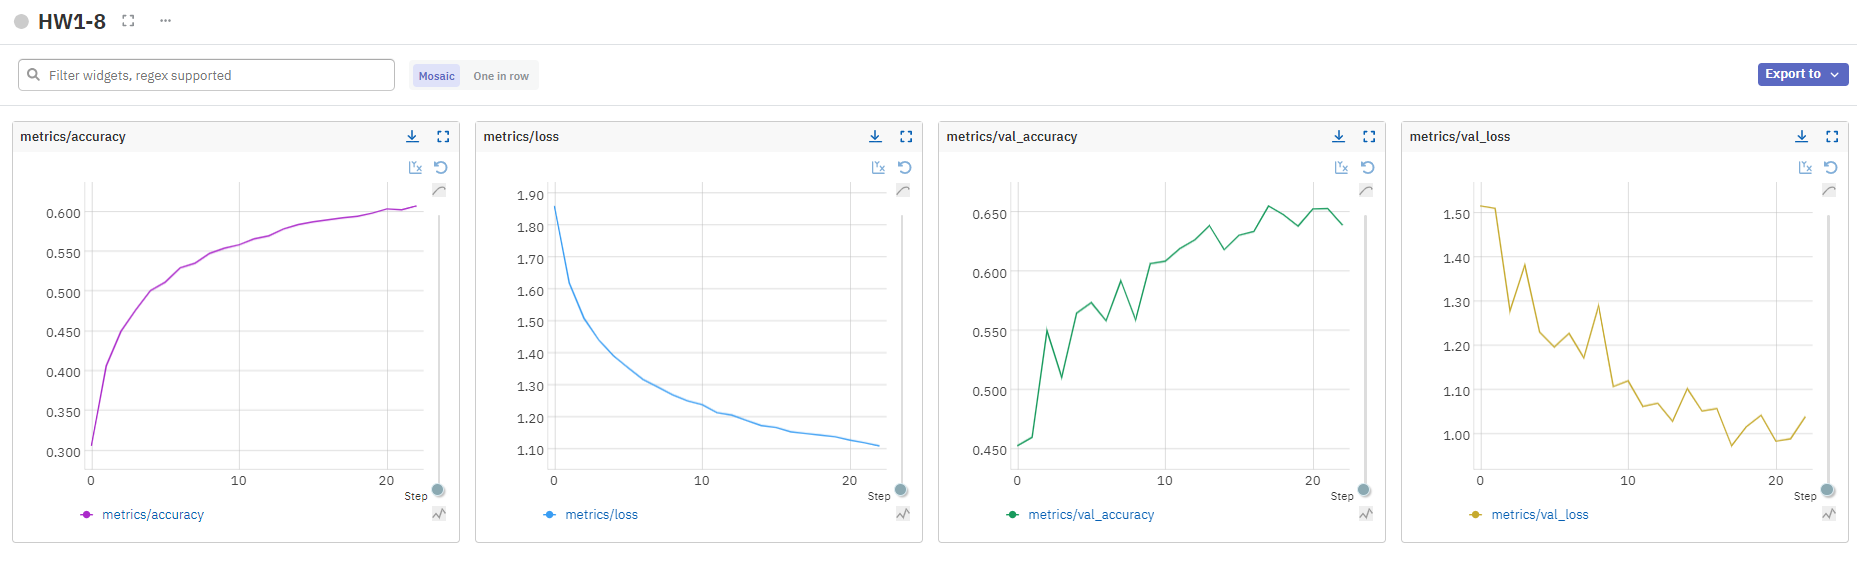

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

neptune_logger = NeptuneLogger()

run = neptune.init_run(
    project="vladislavermakovich/HW33",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)


model = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)


model.fit(custom_generator(train_images, train_labels, batch_size=32),
          steps_per_epoch=int(len(train_images) / 32),
          epochs=30,
          validation_data=(test_images, test_labels),
          callbacks=[neptune_logger, early_stopping, reduce_lr])

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/HW33/e/HW1-9
Epoch 1/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.2295 - loss: 2.0283 - val_accuracy: 0.3973 - val_loss: 1.6233 - learning_rate: 0.0010
Epoch 2/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.3583 - loss: 1.7122 - val_accuracy: 0.4143 - val_loss: 1.6153 - learning_rate: 0.0010
Epoch 3/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.4153 - loss: 1.5983 - val_accuracy: 0.5186 - val_loss: 1.3314 - learning_rate: 0.0010
Epoch 4/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.4533 - loss: 1.5079 - val_accuracy: 0.5376 - val_loss: 1.2759 - learning_rate: 0.0010
Epoch 5/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.4748 - loss: 1.4488 - val_accuracy: 0.5121 - val_loss: 1.3495 - learning_rate: 0.0010
Epoch 6/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.4942 - loss: 1.4221 - val_accuracy: 

0.6480

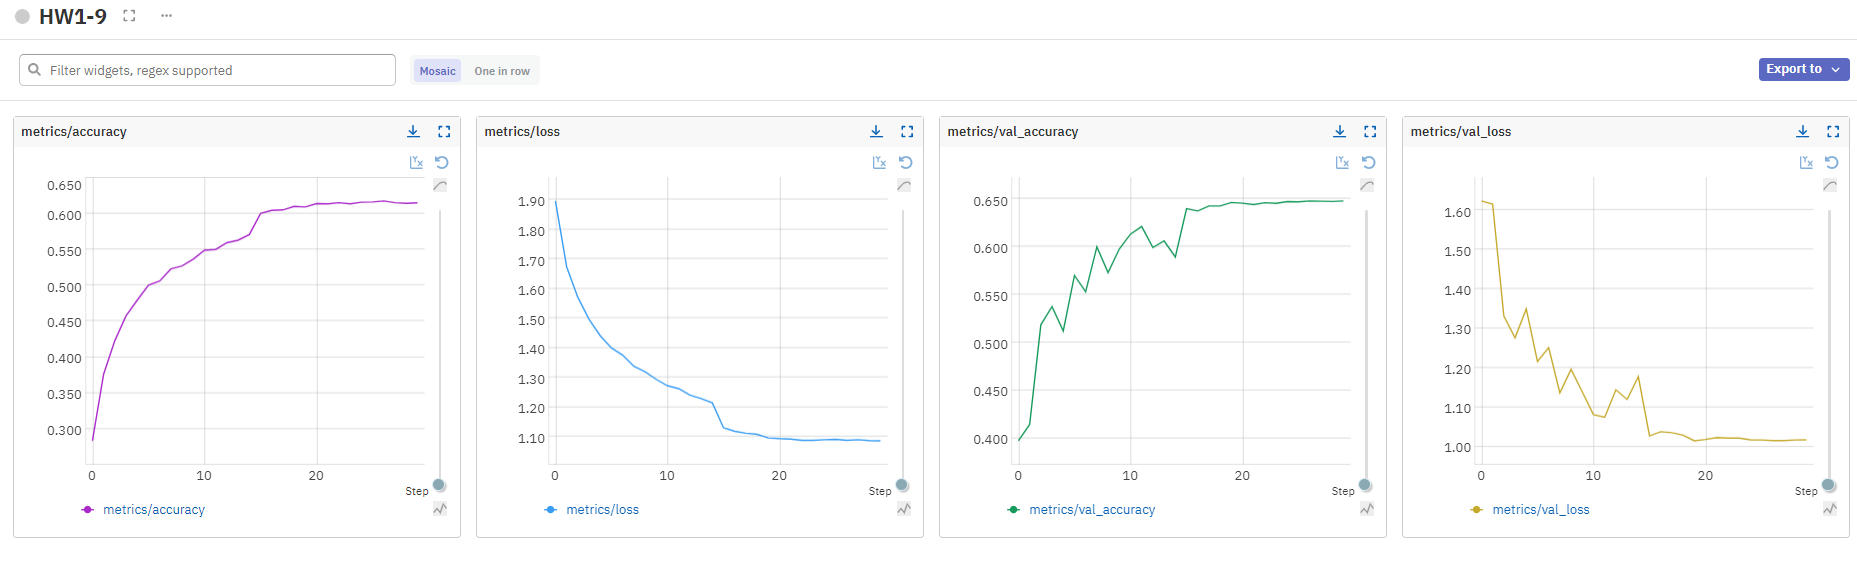

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import datetime


model = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

neptune_logger = NeptuneLogger()

run = neptune.init_run(
    project="vladislavermakovich/HW33",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)

best_model_path = "best_model_my.keras"
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


model.fit(custom_generator(train_images, train_labels, batch_size=32),
          steps_per_epoch=int(len(train_images) / 32),
          epochs=30,
          validation_data=(test_images, test_labels),
          callbacks=[neptune_logger, early_stopping, reduce_lr,checkpoint_callback])

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/HW33/e/HW1-17
Epoch 1/30
1559/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2907 - loss: 1.8938
Epoch 1: val_accuracy improved from -inf to 0.49830, saving model to best_model_my.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.2909 - loss: 1.8934 - val_accuracy: 0.4983 - val_loss: 1.3816 - learning_rate: 0.0010
Epoch 2/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4519 - loss: 1.5061
Epoch 2: val_accuracy improved from 0.49830 to 0.54280, saving model to best_model_my.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.4519 - loss: 1.5061 - val_accuracy: 0.5428 - val_loss: 1.2636 - learning_rate: 0.0010
Epoch 3/30
1561/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5063 - loss: 1.3737
Epoch 3: val_accuracy improved from 0.54280 to 0.58500, saving model to best_model_my.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy

0.7264

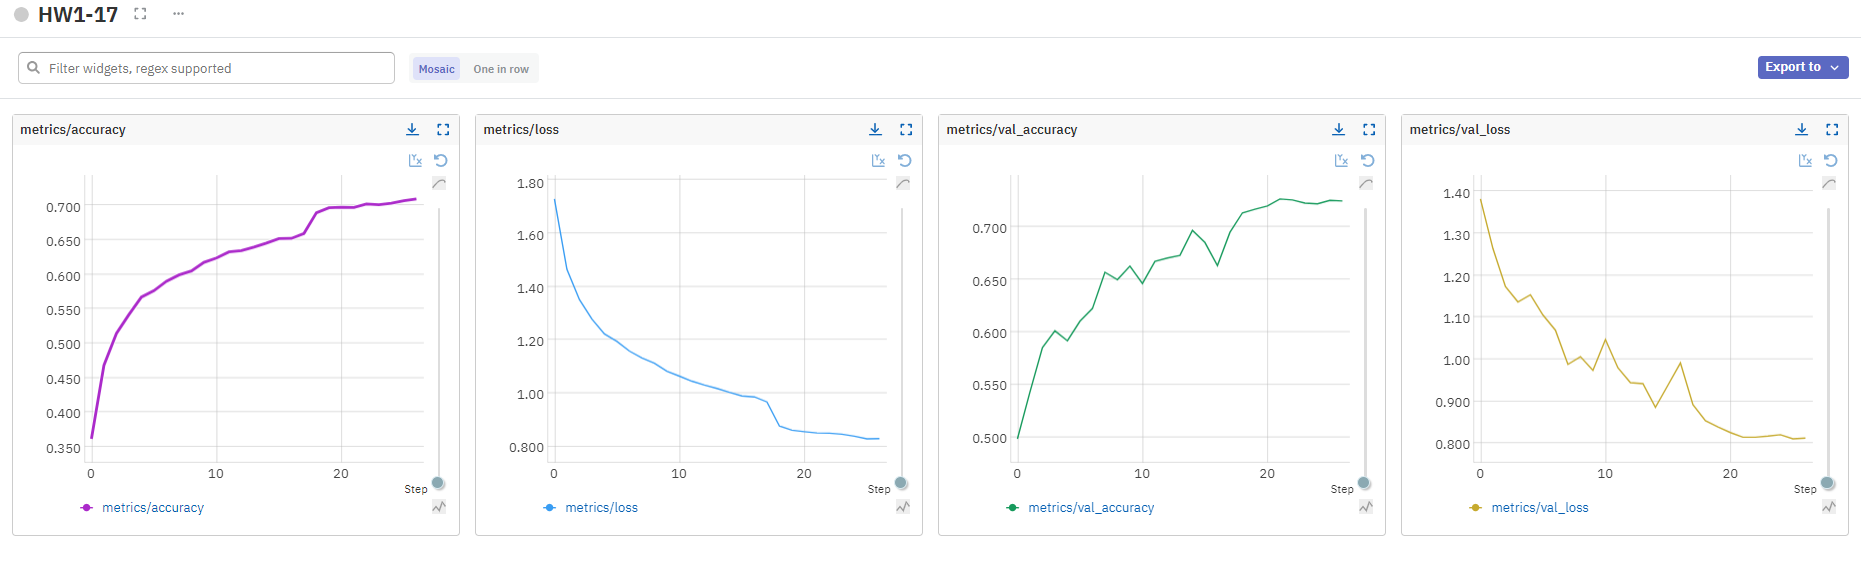

# **Обучение через датаген**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import datetime


model = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

neptune_logger = NeptuneLogger()

run = neptune.init_run(
    project="vladislavermakovich/HW33",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)

best_model_path = "best_model.keras"
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=int(len(train_images) / 32),
          epochs=30,
          validation_data=(test_images, test_labels),
          callbacks=[neptune_logger, early_stopping, reduce_lr,checkpoint_callback])

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/HW33/e/HW1-14
Epoch 1/30
1556/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3028 - loss: 1.8553
Epoch 1: val_accuracy improved from -inf to 0.49240, saving model to best_model.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.3032 - loss: 1.8544 - val_accuracy: 0.4924 - val_loss: 1.4030 - learning_rate: 0.0010
Epoch 2/30
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.4688 - loss: 1.3958
Epoch 2: val_accuracy did not improve from 0.49240
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - accuracy: 0.4688 - loss: 1.3958 - val_accuracy: 0.4881 - val_loss: 1.4083 - learning_rate: 0.0010
Epoch 3/30
1559/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5082 - loss: 1.3616
Epoch 3: val_accuracy improved from 0.49240 to 0.55680, saving model to best_model.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.5082 - loss: 1.3615 - val_accuracy: 0.5568

0.7175

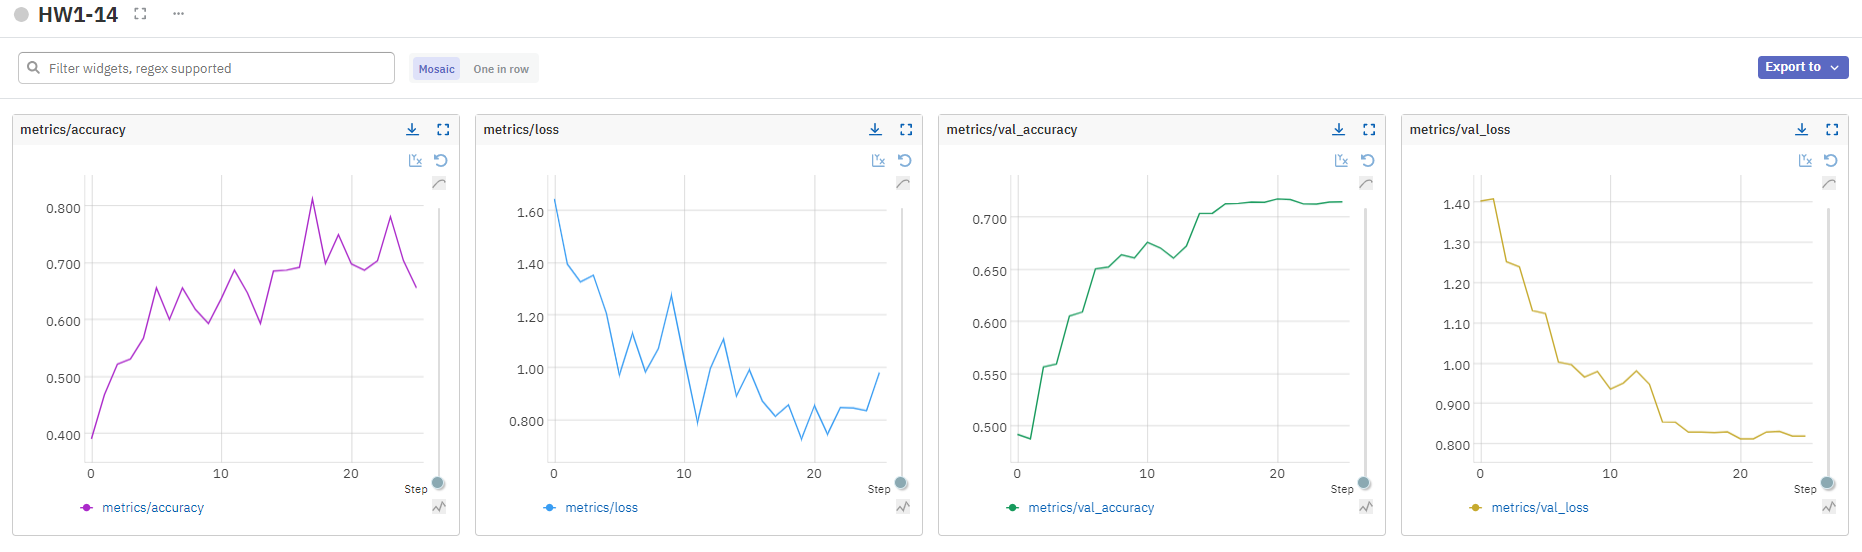

# **Сравнение собственного и датагена с ноутбука**

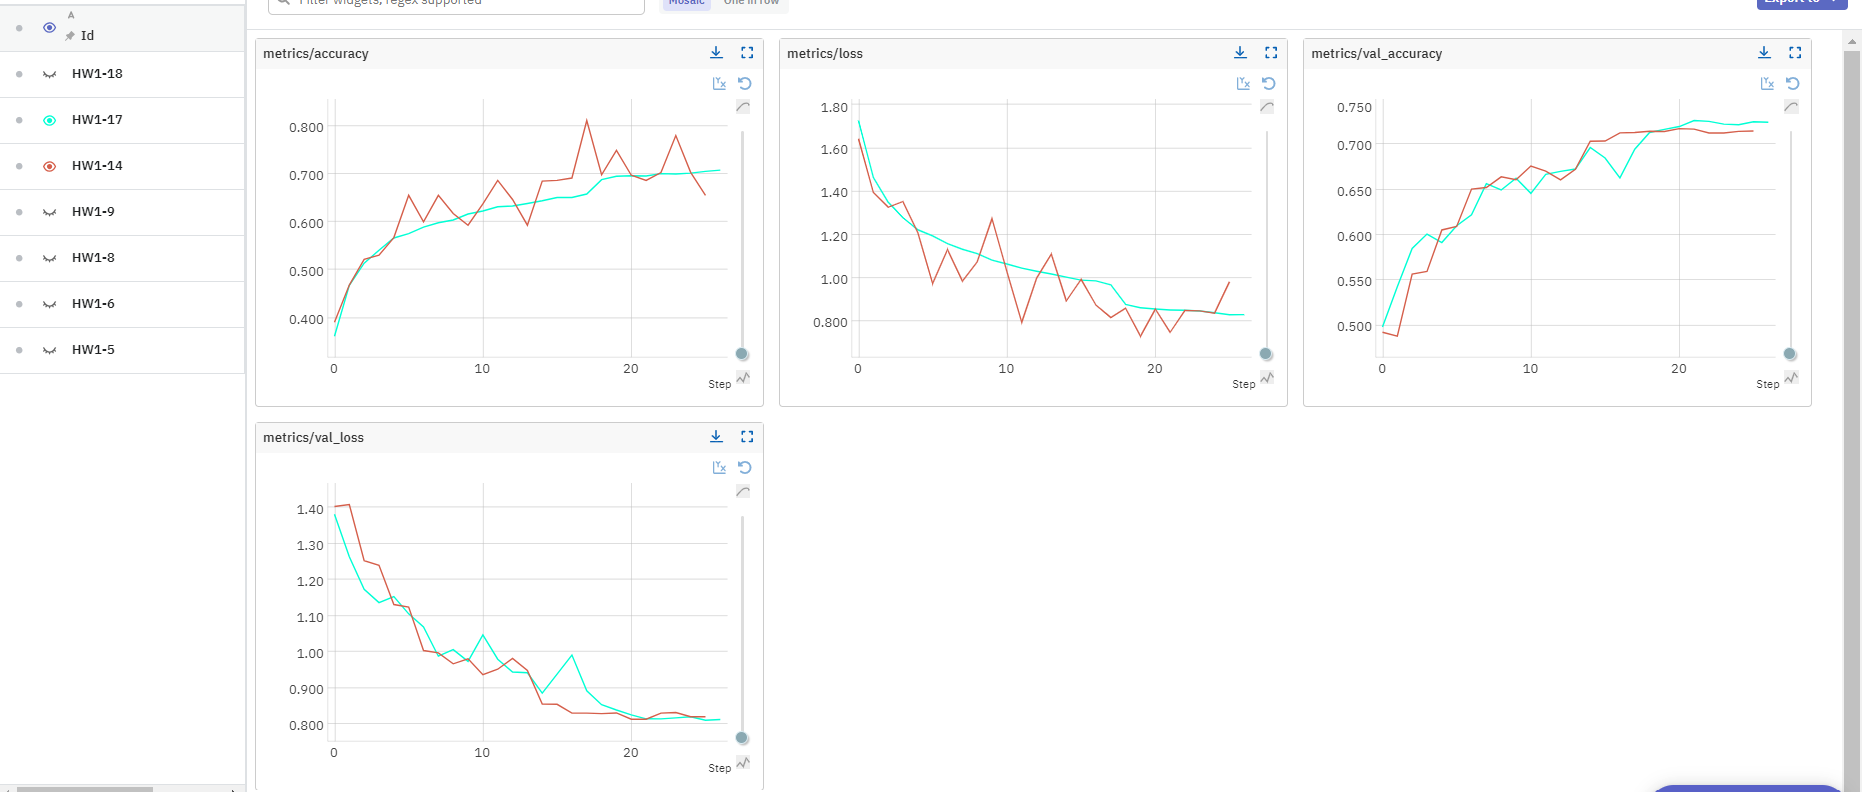

14 - датаген - 0.7175

17 - собственый(оказался лучше) - 0.7264

# **Датаген и оптуна**

In [ ]:
import optuna
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


def create_model(trial):
    num_filters_1 = trial.suggest_int('num_filters_1', 16, 64)
    num_filters_2 = trial.suggest_int('num_filters_2', 32, 128)
    num_filters_3 = trial.suggest_int('num_filters_3', 32, 128)
    dense_units = trial.suggest_int('dense_units', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential([
        Input(shape=(32, 32, 3)),
        Conv2D(num_filters_1, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(num_filters_2, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(num_filters_3, (3, 3), activation='relu'),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model, learning_rate

def objective(trial):
    model, learning_rate = create_model(trial)

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)
    best_model_path = "best_model_opt.keras"
    checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
                        steps_per_epoch=int(len(train_images) / 32),
                        epochs=20,
                        validation_data=(test_images, test_labels),
                        callbacks=[early_stopping, reduce_lr, checkpoint_callback],
                        verbose=0)

    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

best_params = study.best_trial.params
print(f"Лучшие параметры: {best_params}")


[I 2024-07-07 18:03:11,392] A new study created in memory with name: no-name-db42b298-b4a8-47f6-9901-61bcbbd4c95b



Epoch 1: val_accuracy improved from -inf to 0.54830, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.54830

Epoch 3: val_accuracy improved from 0.54830 to 0.61170, saving model to best_model_opt.keras

Epoch 4: val_accuracy did not improve from 0.61170

Epoch 5: val_accuracy improved from 0.61170 to 0.64660, saving model to best_model_opt.keras

Epoch 6: val_accuracy did not improve from 0.64660

Epoch 7: val_accuracy improved from 0.64660 to 0.67190, saving model to best_model_opt.keras

Epoch 8: val_accuracy improved from 0.67190 to 0.67220, saving model to best_model_opt.keras

Epoch 9: val_accuracy improved from 0.67220 to 0.68260, saving model to best_model_opt.keras

Epoch 10: val_accuracy improved from 0.68260 to 0.68550, saving model to best_model_opt.keras

Epoch 11: val_accuracy improved from 0.68550 to 0.69340, saving model to best_model_opt.keras

Epoch 12: val_accuracy did not improve from 0.69340

Epoch 13: val_accuracy improved from 0.

[I 2024-07-07 18:08:48,270] Trial 0 finished with value: 0.7135000228881836 and parameters: {'num_filters_1': 61, 'num_filters_2': 92, 'num_filters_3': 89, 'dense_units': 135, 'learning_rate': 0.00020823784244359877}. Best is trial 0 with value: 0.7135000228881836.



Epoch 1: val_accuracy improved from -inf to 0.54690, saving model to best_model_opt.keras

Epoch 2: val_accuracy improved from 0.54690 to 0.54800, saving model to best_model_opt.keras

Epoch 3: val_accuracy improved from 0.54800 to 0.62490, saving model to best_model_opt.keras

Epoch 4: val_accuracy did not improve from 0.62490

Epoch 5: val_accuracy improved from 0.62490 to 0.64550, saving model to best_model_opt.keras

Epoch 6: val_accuracy did not improve from 0.64550

Epoch 7: val_accuracy improved from 0.64550 to 0.67700, saving model to best_model_opt.keras

Epoch 8: val_accuracy did not improve from 0.67700

Epoch 9: val_accuracy improved from 0.67700 to 0.68720, saving model to best_model_opt.keras

Epoch 10: val_accuracy did not improve from 0.68720

Epoch 11: val_accuracy improved from 0.68720 to 0.70840, saving model to best_model_opt.keras

Epoch 12: val_accuracy did not improve from 0.70840

Epoch 13: val_accuracy improved from 0.70840 to 0.71080, saving model to best_mod

[I 2024-07-07 18:13:24,244] Trial 1 finished with value: 0.725600004196167 and parameters: {'num_filters_1': 18, 'num_filters_2': 121, 'num_filters_3': 111, 'dense_units': 113, 'learning_rate': 0.0013484476197591893}. Best is trial 1 with value: 0.725600004196167.



Epoch 1: val_accuracy improved from -inf to 0.52810, saving model to best_model_opt.keras

Epoch 2: val_accuracy improved from 0.52810 to 0.53190, saving model to best_model_opt.keras

Epoch 3: val_accuracy improved from 0.53190 to 0.59970, saving model to best_model_opt.keras

Epoch 4: val_accuracy did not improve from 0.59970

Epoch 5: val_accuracy improved from 0.59970 to 0.63590, saving model to best_model_opt.keras

Epoch 6: val_accuracy did not improve from 0.63590

Epoch 7: val_accuracy improved from 0.63590 to 0.64010, saving model to best_model_opt.keras

Epoch 8: val_accuracy improved from 0.64010 to 0.64420, saving model to best_model_opt.keras

Epoch 9: val_accuracy improved from 0.64420 to 0.68090, saving model to best_model_opt.keras

Epoch 10: val_accuracy improved from 0.68090 to 0.68170, saving model to best_model_opt.keras

Epoch 11: val_accuracy improved from 0.68170 to 0.68590, saving model to best_model_opt.keras

Epoch 12: val_accuracy did not improve from 0.6859

[I 2024-07-07 18:18:16,133] Trial 2 finished with value: 0.7124000191688538 and parameters: {'num_filters_1': 33, 'num_filters_2': 122, 'num_filters_3': 73, 'dense_units': 87, 'learning_rate': 7.559884722930537e-05}. Best is trial 1 with value: 0.725600004196167.



Epoch 1: val_accuracy improved from -inf to 0.51470, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.51470

Epoch 3: val_accuracy improved from 0.51470 to 0.56230, saving model to best_model_opt.keras

Epoch 4: val_accuracy did not improve from 0.56230

Epoch 5: val_accuracy improved from 0.56230 to 0.57400, saving model to best_model_opt.keras

Epoch 6: val_accuracy did not improve from 0.57400

Epoch 7: val_accuracy improved from 0.57400 to 0.61440, saving model to best_model_opt.keras

Epoch 8: val_accuracy did not improve from 0.61440

Epoch 9: val_accuracy improved from 0.61440 to 0.63590, saving model to best_model_opt.keras

Epoch 10: val_accuracy did not improve from 0.63590

Epoch 11: val_accuracy improved from 0.63590 to 0.64160, saving model to best_model_opt.keras

Epoch 12: val_accuracy did not improve from 0.64160

Epoch 13: val_accuracy improved from 0.64160 to 0.64680, saving model to best_model_opt.keras

Epoch 14: val_accuracy did n

[I 2024-07-07 18:23:06,340] Trial 3 finished with value: 0.6840000152587891 and parameters: {'num_filters_1': 54, 'num_filters_2': 60, 'num_filters_3': 40, 'dense_units': 68, 'learning_rate': 0.0015481049104789063}. Best is trial 1 with value: 0.725600004196167.



Epoch 1: val_accuracy improved from -inf to 0.50660, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.50660

Epoch 3: val_accuracy improved from 0.50660 to 0.55710, saving model to best_model_opt.keras

Epoch 4: val_accuracy did not improve from 0.55710

Epoch 5: val_accuracy improved from 0.55710 to 0.60490, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.60490 to 0.60990, saving model to best_model_opt.keras

Epoch 7: val_accuracy improved from 0.60990 to 0.63050, saving model to best_model_opt.keras

Epoch 8: val_accuracy improved from 0.63050 to 0.63220, saving model to best_model_opt.keras

Epoch 9: val_accuracy improved from 0.63220 to 0.63870, saving model to best_model_opt.keras

Epoch 10: val_accuracy did not improve from 0.63870

Epoch 11: val_accuracy improved from 0.63870 to 0.67180, saving model to best_model_opt.keras

Epoch 12: val_accuracy did not improve from 0.67180

Epoch 13: val_accuracy improved from 0.

[I 2024-07-07 18:28:06,454] Trial 4 finished with value: 0.6948000192642212 and parameters: {'num_filters_1': 43, 'num_filters_2': 75, 'num_filters_3': 33, 'dense_units': 57, 'learning_rate': 0.0002653656934575849}. Best is trial 1 with value: 0.725600004196167.



Epoch 1: val_accuracy improved from -inf to 0.51820, saving model to best_model_opt.keras

Epoch 2: val_accuracy improved from 0.51820 to 0.51940, saving model to best_model_opt.keras

Epoch 3: val_accuracy improved from 0.51940 to 0.60910, saving model to best_model_opt.keras

Epoch 4: val_accuracy did not improve from 0.60910

Epoch 5: val_accuracy improved from 0.60910 to 0.63460, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.63460 to 0.63950, saving model to best_model_opt.keras

Epoch 7: val_accuracy improved from 0.63950 to 0.66110, saving model to best_model_opt.keras

Epoch 8: val_accuracy did not improve from 0.66110

Epoch 9: val_accuracy improved from 0.66110 to 0.67400, saving model to best_model_opt.keras

Epoch 10: val_accuracy did not improve from 0.67400

Epoch 11: val_accuracy improved from 0.67400 to 0.68580, saving model to best_model_opt.keras

Epoch 12: val_accuracy did not improve from 0.68580

Epoch 13: val_accuracy did not improve 

[I 2024-07-07 18:32:40,212] Trial 5 finished with value: 0.7303000092506409 and parameters: {'num_filters_1': 33, 'num_filters_2': 102, 'num_filters_3': 53, 'dense_units': 164, 'learning_rate': 0.00025773871394462047}. Best is trial 5 with value: 0.7303000092506409.



Epoch 1: val_accuracy improved from -inf to 0.52820, saving model to best_model_opt.keras

Epoch 2: val_accuracy improved from 0.52820 to 0.54170, saving model to best_model_opt.keras

Epoch 3: val_accuracy improved from 0.54170 to 0.58680, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.58680 to 0.60320, saving model to best_model_opt.keras

Epoch 5: val_accuracy improved from 0.60320 to 0.63550, saving model to best_model_opt.keras

Epoch 6: val_accuracy did not improve from 0.63550

Epoch 7: val_accuracy improved from 0.63550 to 0.65770, saving model to best_model_opt.keras

Epoch 8: val_accuracy did not improve from 0.65770

Epoch 9: val_accuracy improved from 0.65770 to 0.67990, saving model to best_model_opt.keras

Epoch 10: val_accuracy did not improve from 0.67990

Epoch 11: val_accuracy improved from 0.67990 to 0.68740, saving model to best_model_opt.keras

Epoch 12: val_accuracy improved from 0.68740 to 0.68870, saving model to best_model_opt.kera

[I 2024-07-07 18:37:15,458] Trial 6 finished with value: 0.7210999727249146 and parameters: {'num_filters_1': 21, 'num_filters_2': 116, 'num_filters_3': 80, 'dense_units': 246, 'learning_rate': 0.0007733637483211848}. Best is trial 5 with value: 0.7303000092506409.



Epoch 1: val_accuracy improved from -inf to 0.52030, saving model to best_model_opt.keras

Epoch 2: val_accuracy improved from 0.52030 to 0.52250, saving model to best_model_opt.keras

Epoch 3: val_accuracy improved from 0.52250 to 0.57240, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.57240 to 0.57910, saving model to best_model_opt.keras

Epoch 5: val_accuracy improved from 0.57910 to 0.60370, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.60370 to 0.61490, saving model to best_model_opt.keras

Epoch 7: val_accuracy improved from 0.61490 to 0.66800, saving model to best_model_opt.keras

Epoch 8: val_accuracy improved from 0.66800 to 0.66840, saving model to best_model_opt.keras

Epoch 9: val_accuracy did not improve from 0.66840

Epoch 10: val_accuracy improved from 0.66840 to 0.66900, saving model to best_model_opt.keras

Epoch 11: val_accuracy did not improve from 0.66900

Epoch 12: val_accuracy did not improve from 0.6690

[I 2024-07-07 18:41:51,037] Trial 7 finished with value: 0.6890000104904175 and parameters: {'num_filters_1': 27, 'num_filters_2': 121, 'num_filters_3': 82, 'dense_units': 99, 'learning_rate': 0.0012996316540092579}. Best is trial 5 with value: 0.7303000092506409.



Epoch 1: val_accuracy improved from -inf to 0.52460, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.52460

Epoch 3: val_accuracy improved from 0.52460 to 0.57520, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.57520 to 0.57930, saving model to best_model_opt.keras

Epoch 5: val_accuracy improved from 0.57930 to 0.60370, saving model to best_model_opt.keras

Epoch 6: val_accuracy did not improve from 0.60370

Epoch 7: val_accuracy improved from 0.60370 to 0.62250, saving model to best_model_opt.keras

Epoch 8: val_accuracy did not improve from 0.62250

Epoch 9: val_accuracy improved from 0.62250 to 0.66090, saving model to best_model_opt.keras

Epoch 10: val_accuracy did not improve from 0.66090

Epoch 11: val_accuracy did not improve from 0.66090

Epoch 12: val_accuracy did not improve from 0.66090

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 13: val_accuracy did not improve from 

[I 2024-07-07 18:45:39,166] Trial 8 finished with value: 0.6597999930381775 and parameters: {'num_filters_1': 58, 'num_filters_2': 108, 'num_filters_3': 51, 'dense_units': 44, 'learning_rate': 5.0462248830627136e-05}. Best is trial 5 with value: 0.7303000092506409.



Epoch 1: val_accuracy improved from -inf to 0.52720, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.52720

Epoch 3: val_accuracy improved from 0.52720 to 0.60740, saving model to best_model_opt.keras

Epoch 4: val_accuracy did not improve from 0.60740

Epoch 5: val_accuracy improved from 0.60740 to 0.62300, saving model to best_model_opt.keras

Epoch 6: val_accuracy did not improve from 0.62300

Epoch 7: val_accuracy did not improve from 0.62300

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 8: val_accuracy did not improve from 0.62300

Epoch 9: val_accuracy improved from 0.62300 to 0.67810, saving model to best_model_opt.keras

Epoch 10: val_accuracy did not improve from 0.67810

Epoch 11: val_accuracy improved from 0.67810 to 0.68560, saving model to best_model_opt.keras

Epoch 12: val_accuracy did not improve from 0.68560

Epoch 13: val_accuracy improved from 0.68560 to 0.69300, saving model to best_model_opt

[I 2024-07-07 18:49:32,395] Trial 9 finished with value: 0.699400007724762 and parameters: {'num_filters_1': 16, 'num_filters_2': 77, 'num_filters_3': 58, 'dense_units': 234, 'learning_rate': 0.002050008752166209}. Best is trial 5 with value: 0.7303000092506409.



Epoch 1: val_accuracy improved from -inf to 0.54380, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.54380

Epoch 3: val_accuracy improved from 0.54380 to 0.58050, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.58050 to 0.58430, saving model to best_model_opt.keras

Epoch 5: val_accuracy improved from 0.58430 to 0.61400, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.61400 to 0.62020, saving model to best_model_opt.keras

Epoch 7: val_accuracy improved from 0.62020 to 0.64870, saving model to best_model_opt.keras

Epoch 8: val_accuracy improved from 0.64870 to 0.65680, saving model to best_model_opt.keras

Epoch 9: val_accuracy improved from 0.65680 to 0.66670, saving model to best_model_opt.keras

Epoch 10: val_accuracy did not improve from 0.66670

Epoch 11: val_accuracy improved from 0.66670 to 0.70440, saving model to best_model_opt.keras

Epoch 12: val_accuracy did not improve from 0.7044

[I 2024-07-07 18:54:07,655] Trial 10 finished with value: 0.7436000108718872 and parameters: {'num_filters_1': 43, 'num_filters_2': 34, 'num_filters_3': 122, 'dense_units': 187, 'learning_rate': 1.2574799722487399e-05}. Best is trial 10 with value: 0.7436000108718872.



Epoch 1: val_accuracy improved from -inf to 0.56570, saving model to best_model_opt.keras

Epoch 2: val_accuracy improved from 0.56570 to 0.56940, saving model to best_model_opt.keras

Epoch 3: val_accuracy improved from 0.56940 to 0.61330, saving model to best_model_opt.keras

Epoch 4: val_accuracy did not improve from 0.61330

Epoch 5: val_accuracy improved from 0.61330 to 0.65500, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.65500 to 0.65590, saving model to best_model_opt.keras

Epoch 7: val_accuracy improved from 0.65590 to 0.66870, saving model to best_model_opt.keras

Epoch 8: val_accuracy did not improve from 0.66870

Epoch 9: val_accuracy improved from 0.66870 to 0.69130, saving model to best_model_opt.keras

Epoch 10: val_accuracy improved from 0.69130 to 0.69310, saving model to best_model_opt.keras

Epoch 11: val_accuracy improved from 0.69310 to 0.70440, saving model to best_model_opt.keras

Epoch 12: val_accuracy improved from 0.70440 to 0.

[I 2024-07-07 18:58:43,988] Trial 11 finished with value: 0.742900013923645 and parameters: {'num_filters_1': 43, 'num_filters_2': 37, 'num_filters_3': 125, 'dense_units': 176, 'learning_rate': 1.0419660465802811e-05}. Best is trial 10 with value: 0.7436000108718872.



Epoch 1: val_accuracy improved from -inf to 0.55660, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.55660

Epoch 3: val_accuracy improved from 0.55660 to 0.58850, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.58850 to 0.59620, saving model to best_model_opt.keras

Epoch 5: val_accuracy improved from 0.59620 to 0.64100, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.64100 to 0.64220, saving model to best_model_opt.keras

Epoch 7: val_accuracy improved from 0.64220 to 0.67580, saving model to best_model_opt.keras

Epoch 8: val_accuracy improved from 0.67580 to 0.67670, saving model to best_model_opt.keras

Epoch 9: val_accuracy did not improve from 0.67670

Epoch 10: val_accuracy improved from 0.67670 to 0.68270, saving model to best_model_opt.keras

Epoch 11: val_accuracy improved from 0.68270 to 0.69350, saving model to best_model_opt.keras

Epoch 12: val_accuracy improved from 0.69350 to 0.

[I 2024-07-07 19:03:32,012] Trial 12 finished with value: 0.7164999842643738 and parameters: {'num_filters_1': 46, 'num_filters_2': 35, 'num_filters_3': 126, 'dense_units': 189, 'learning_rate': 1.237497456320289e-05}. Best is trial 10 with value: 0.7436000108718872.



Epoch 1: val_accuracy improved from -inf to 0.54750, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.54750

Epoch 3: val_accuracy improved from 0.54750 to 0.60550, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.60550 to 0.61780, saving model to best_model_opt.keras

Epoch 5: val_accuracy improved from 0.61780 to 0.66750, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.66750 to 0.66960, saving model to best_model_opt.keras

Epoch 7: val_accuracy did not improve from 0.66960

Epoch 8: val_accuracy did not improve from 0.66960

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 9: val_accuracy did not improve from 0.66960

Epoch 10: val_accuracy did not improve from 0.66960

Epoch 11: val_accuracy improved from 0.66960 to 0.72780, saving model to best_model_opt.keras

Epoch 12: val_accuracy improved from 0.72780 to 0.72820, saving model to best_model_opt.keras

Epo

[I 2024-07-07 19:08:21,749] Trial 13 finished with value: 0.7427999973297119 and parameters: {'num_filters_1': 49, 'num_filters_2': 39, 'num_filters_3': 127, 'dense_units': 198, 'learning_rate': 1.0562377174700448e-05}. Best is trial 10 with value: 0.7436000108718872.



Epoch 1: val_accuracy improved from -inf to 0.54980, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.54980

Epoch 3: val_accuracy improved from 0.54980 to 0.61260, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.61260 to 0.61530, saving model to best_model_opt.keras

Epoch 5: val_accuracy improved from 0.61530 to 0.64880, saving model to best_model_opt.keras

Epoch 6: val_accuracy did not improve from 0.64880

Epoch 7: val_accuracy improved from 0.64880 to 0.65660, saving model to best_model_opt.keras

Epoch 8: val_accuracy improved from 0.65660 to 0.65840, saving model to best_model_opt.keras

Epoch 9: val_accuracy improved from 0.65840 to 0.69510, saving model to best_model_opt.keras

Epoch 10: val_accuracy improved from 0.69510 to 0.69590, saving model to best_model_opt.keras

Epoch 11: val_accuracy improved from 0.69590 to 0.70190, saving model to best_model_opt.keras

Epoch 12: val_accuracy improved from 0.70190 to 0.

[I 2024-07-07 19:12:56,935] Trial 14 finished with value: 0.7328000068664551 and parameters: {'num_filters_1': 36, 'num_filters_2': 50, 'num_filters_3': 105, 'dense_units': 205, 'learning_rate': 0.009331811545060707}. Best is trial 10 with value: 0.7436000108718872.



Epoch 1: val_accuracy improved from -inf to 0.53380, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.53380

Epoch 3: val_accuracy improved from 0.53380 to 0.61780, saving model to best_model_opt.keras

Epoch 4: val_accuracy did not improve from 0.61780

Epoch 5: val_accuracy improved from 0.61780 to 0.62430, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.62430 to 0.62790, saving model to best_model_opt.keras

Epoch 7: val_accuracy improved from 0.62790 to 0.64870, saving model to best_model_opt.keras

Epoch 8: val_accuracy did not improve from 0.64870

Epoch 9: val_accuracy improved from 0.64870 to 0.65480, saving model to best_model_opt.keras

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 10: val_accuracy did not improve from 0.65480

Epoch 11: val_accuracy improved from 0.65480 to 0.71470, saving model to best_model_opt.keras

Epoch 12: val_accuracy improved from 0.71470 to 0.71480

[I 2024-07-07 19:17:34,082] Trial 15 finished with value: 0.7250000238418579 and parameters: {'num_filters_1': 40, 'num_filters_2': 60, 'num_filters_3': 110, 'dense_units': 153, 'learning_rate': 2.9942657270010766e-05}. Best is trial 10 with value: 0.7436000108718872.



Epoch 1: val_accuracy improved from -inf to 0.52090, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.52090

Epoch 3: val_accuracy improved from 0.52090 to 0.58650, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.58650 to 0.59450, saving model to best_model_opt.keras

Epoch 5: val_accuracy improved from 0.59450 to 0.62630, saving model to best_model_opt.keras

Epoch 6: val_accuracy did not improve from 0.62630

Epoch 7: val_accuracy improved from 0.62630 to 0.66130, saving model to best_model_opt.keras

Epoch 8: val_accuracy improved from 0.66130 to 0.66290, saving model to best_model_opt.keras

Epoch 9: val_accuracy improved from 0.66290 to 0.67350, saving model to best_model_opt.keras

Epoch 10: val_accuracy improved from 0.67350 to 0.67540, saving model to best_model_opt.keras

Epoch 11: val_accuracy improved from 0.67540 to 0.68610, saving model to best_model_opt.keras

Epoch 12: val_accuracy did not improve from 0.6861

[I 2024-07-07 19:22:09,732] Trial 16 finished with value: 0.7278000116348267 and parameters: {'num_filters_1': 52, 'num_filters_2': 32, 'num_filters_3': 97, 'dense_units': 181, 'learning_rate': 2.5136202408892244e-05}. Best is trial 10 with value: 0.7436000108718872.



Epoch 1: val_accuracy improved from -inf to 0.52310, saving model to best_model_opt.keras

Epoch 2: val_accuracy improved from 0.52310 to 0.53100, saving model to best_model_opt.keras

Epoch 3: val_accuracy improved from 0.53100 to 0.59550, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.59550 to 0.59750, saving model to best_model_opt.keras

Epoch 5: val_accuracy improved from 0.59750 to 0.62910, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.62910 to 0.63040, saving model to best_model_opt.keras

Epoch 7: val_accuracy improved from 0.63040 to 0.67950, saving model to best_model_opt.keras

Epoch 8: val_accuracy improved from 0.67950 to 0.68250, saving model to best_model_opt.keras

Epoch 9: val_accuracy improved from 0.68250 to 0.69210, saving model to best_model_opt.keras

Epoch 10: val_accuracy did not improve from 0.69210

Epoch 11: val_accuracy improved from 0.69210 to 0.69990, saving model to best_model_opt.keras

Epoch 12

[I 2024-07-07 19:26:17,604] Trial 17 finished with value: 0.7116000056266785 and parameters: {'num_filters_1': 39, 'num_filters_2': 48, 'num_filters_3': 119, 'dense_units': 213, 'learning_rate': 0.00011750619752911451}. Best is trial 10 with value: 0.7436000108718872.



Epoch 1: val_accuracy improved from -inf to 0.53340, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.53340

Epoch 3: val_accuracy improved from 0.53340 to 0.62630, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.62630 to 0.62730, saving model to best_model_opt.keras

Epoch 5: val_accuracy did not improve from 0.62730

Epoch 6: val_accuracy did not improve from 0.62730

Epoch 7: val_accuracy improved from 0.62730 to 0.66360, saving model to best_model_opt.keras

Epoch 8: val_accuracy did not improve from 0.66360

Epoch 9: val_accuracy improved from 0.66360 to 0.67650, saving model to best_model_opt.keras

Epoch 10: val_accuracy improved from 0.67650 to 0.69010, saving model to best_model_opt.keras

Epoch 11: val_accuracy improved from 0.69010 to 0.71510, saving model to best_model_opt.keras

Epoch 12: val_accuracy did not improve from 0.71510

Epoch 13: val_accuracy did not improve from 0.71510

Epoch 14: val_accuracy did n

[I 2024-07-07 19:31:33,362] Trial 18 finished with value: 0.751800000667572 and parameters: {'num_filters_1': 64, 'num_filters_2': 64, 'num_filters_3': 99, 'dense_units': 129, 'learning_rate': 2.38282399402294e-05}. Best is trial 18 with value: 0.751800000667572.



Epoch 1: val_accuracy improved from -inf to 0.55330, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.55330

Epoch 3: val_accuracy improved from 0.55330 to 0.61210, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.61210 to 0.62300, saving model to best_model_opt.keras

Epoch 5: val_accuracy improved from 0.62300 to 0.65480, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.65480 to 0.65670, saving model to best_model_opt.keras

Epoch 7: val_accuracy improved from 0.65670 to 0.67170, saving model to best_model_opt.keras

Epoch 8: val_accuracy did not improve from 0.67170

Epoch 9: val_accuracy improved from 0.67170 to 0.68680, saving model to best_model_opt.keras

Epoch 10: val_accuracy improved from 0.68680 to 0.68810, saving model to best_model_opt.keras

Epoch 11: val_accuracy improved from 0.68810 to 0.69930, saving model to best_model_opt.keras

Epoch 12: val_accuracy improved from 0.69930 to 0.

[I 2024-07-07 19:36:54,968] Trial 19 finished with value: 0.7430999875068665 and parameters: {'num_filters_1': 64, 'num_filters_2': 65, 'num_filters_3': 98, 'dense_units': 132, 'learning_rate': 2.769525571741153e-05}. Best is trial 18 with value: 0.751800000667572.



Epoch 1: val_accuracy improved from -inf to 0.53320, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.53320

Epoch 3: val_accuracy improved from 0.53320 to 0.60500, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.60500 to 0.60800, saving model to best_model_opt.keras

Epoch 5: val_accuracy improved from 0.60800 to 0.62980, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.62980 to 0.63610, saving model to best_model_opt.keras

Epoch 7: val_accuracy improved from 0.63610 to 0.65880, saving model to best_model_opt.keras

Epoch 8: val_accuracy did not improve from 0.65880

Epoch 9: val_accuracy did not improve from 0.65880

Epoch 10: val_accuracy did not improve from 0.65880

Epoch 11: val_accuracy improved from 0.65880 to 0.69810, saving model to best_model_opt.keras

Epoch 12: val_accuracy did not improve from 0.69810

Epoch 13: val_accuracy improved from 0.69810 to 0.70400, saving model to best_mod

[I 2024-07-07 19:42:01,488] Trial 20 finished with value: 0.745199978351593 and parameters: {'num_filters_1': 56, 'num_filters_2': 88, 'num_filters_3': 68, 'dense_units': 119, 'learning_rate': 5.2643342654607525e-05}. Best is trial 18 with value: 0.751800000667572.



Epoch 1: val_accuracy improved from -inf to 0.53910, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.53910

Epoch 3: val_accuracy improved from 0.53910 to 0.61830, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.61830 to 0.62240, saving model to best_model_opt.keras

Epoch 5: val_accuracy improved from 0.62240 to 0.66340, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.66340 to 0.66550, saving model to best_model_opt.keras

Epoch 7: val_accuracy did not improve from 0.66550

Epoch 8: val_accuracy did not improve from 0.66550

Epoch 9: val_accuracy did not improve from 0.66550

Epoch 10: val_accuracy improved from 0.66550 to 0.66710, saving model to best_model_opt.keras

Epoch 11: val_accuracy improved from 0.66710 to 0.69170, saving model to best_model_opt.keras

Epoch 12: val_accuracy did not improve from 0.69170

Epoch 13: val_accuracy improved from 0.69170 to 0.71300, saving model to best_mod

[I 2024-07-07 19:47:17,327] Trial 21 finished with value: 0.7404000163078308 and parameters: {'num_filters_1': 57, 'num_filters_2': 85, 'num_filters_3': 71, 'dense_units': 113, 'learning_rate': 5.0320736703401394e-05}. Best is trial 18 with value: 0.751800000667572.



Epoch 1: val_accuracy improved from -inf to 0.54260, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.54260

Epoch 3: val_accuracy improved from 0.54260 to 0.58440, saving model to best_model_opt.keras

Epoch 4: val_accuracy improved from 0.58440 to 0.58560, saving model to best_model_opt.keras

Epoch 5: val_accuracy improved from 0.58560 to 0.63510, saving model to best_model_opt.keras

Epoch 6: val_accuracy did not improve from 0.63510

Epoch 7: val_accuracy improved from 0.63510 to 0.65600, saving model to best_model_opt.keras

Epoch 8: val_accuracy improved from 0.65600 to 0.65950, saving model to best_model_opt.keras

Epoch 9: val_accuracy did not improve from 0.65950

Epoch 10: val_accuracy did not improve from 0.65950

Epoch 11: val_accuracy improved from 0.65950 to 0.68290, saving model to best_model_opt.keras

Epoch 12: val_accuracy improved from 0.68290 to 0.68750, saving model to best_model_opt.keras

Epoch 13: val_accuracy improved from 0.

[I 2024-07-07 19:52:51,411] Trial 22 finished with value: 0.699999988079071 and parameters: {'num_filters_1': 63, 'num_filters_2': 92, 'num_filters_3': 66, 'dense_units': 147, 'learning_rate': 1.9956756876381966e-05}. Best is trial 18 with value: 0.751800000667572.



Epoch 1: val_accuracy improved from -inf to 0.53700, saving model to best_model_opt.keras

Epoch 2: val_accuracy improved from 0.53700 to 0.54120, saving model to best_model_opt.keras

Epoch 3: val_accuracy improved from 0.54120 to 0.60250, saving model to best_model_opt.keras

Epoch 4: val_accuracy did not improve from 0.60250

Epoch 5: val_accuracy improved from 0.60250 to 0.61910, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.61910 to 0.62520, saving model to best_model_opt.keras

Epoch 7: val_accuracy improved from 0.62520 to 0.65380, saving model to best_model_opt.keras

Epoch 8: val_accuracy did not improve from 0.65380

Epoch 9: val_accuracy improved from 0.65380 to 0.65610, saving model to best_model_opt.keras

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 10: val_accuracy improved from 0.65610 to 0.65930, saving model to best_model_opt.keras

Epoch 11: val_accuracy improved from 0.65930 to 0.71120, saving mo

[I 2024-07-07 19:57:25,929] Trial 23 finished with value: 0.7135999798774719 and parameters: {'num_filters_1': 57, 'num_filters_2': 68, 'num_filters_3': 89, 'dense_units': 119, 'learning_rate': 0.0001161114676958625}. Best is trial 18 with value: 0.751800000667572.



Epoch 1: val_accuracy improved from -inf to 0.54360, saving model to best_model_opt.keras

Epoch 2: val_accuracy did not improve from 0.54360

Epoch 3: val_accuracy improved from 0.54360 to 0.59510, saving model to best_model_opt.keras

Epoch 4: val_accuracy did not improve from 0.59510

Epoch 5: val_accuracy improved from 0.59510 to 0.61300, saving model to best_model_opt.keras

Epoch 6: val_accuracy improved from 0.61300 to 0.61460, saving model to best_model_opt.keras

Epoch 7: val_accuracy improved from 0.61460 to 0.64820, saving model to best_model_opt.keras

Epoch 8: val_accuracy did not improve from 0.64820

Epoch 9: val_accuracy improved from 0.64820 to 0.67520, saving model to best_model_opt.keras

Epoch 10: val_accuracy did not improve from 0.67520

Epoch 11: val_accuracy improved from 0.67520 to 0.69070, saving model to best_model_opt.keras

Epoch 12: val_accuracy did not improve from 0.69070

Epoch 13: val_accuracy improved from 0.69070 to 0.70340, saving model to best_mod

[I 2024-07-07 20:02:10,977] Trial 24 finished with value: 0.7376999855041504 and parameters: {'num_filters_1': 51, 'num_filters_2': 49, 'num_filters_3': 116, 'dense_units': 84, 'learning_rate': 1.8288517944322402e-05}. Best is trial 18 with value: 0.751800000667572.


Лучшие параметры: {'num_filters_1': 64, 'num_filters_2': 64, 'num_filters_3': 99, 'dense_units': 129, 'learning_rate': 2.38282399402294e-05}


**Лучшие параметры: {'num_filters_1': 64, 'num_filters_2': 64, 'num_filters_3': 99, 'dense_units': 129, 'learning_rate': 2.38282399402294e-05}**

In [ ]:

model, _ = create_model(study.best_trial)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


run = neptune.init_run(
    project="vladislavermakovich/HW33",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)

neptune_logger = NeptuneLogger()

best_model_path = "best_model_optuna.keras"
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=int(len(train_images) / 32),
          epochs=50,
          validation_data=(test_images, test_labels),
          callbacks=[neptune_logger, early_stopping, reduce_lr, checkpoint_callback])

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/HW33/e/HW1-18
Epoch 1/50
1560/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3329 - loss: 1.7989
Epoch 1: val_accuracy improved from -inf to 0.54140, saving model to best_model_optuna.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.3331 - loss: 1.7984 - val_accuracy: 0.5414 - val_loss: 1.3070 - learning_rate: 0.0010
Epoch 2/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.5000 - loss: 1.2452
Epoch 2: val_accuracy improved from 0.54140 to 0.54220, saving model to best_model_optuna.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 2s 982us/step - accuracy: 0.5000 - loss: 1.2452 - val_accuracy: 0.5422 - val_loss: 1.2941 - learning_rate: 0.0010
Epoch 3/50
1559/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5351 - loss: 1.3043
Epoch 3: val_accuracy improved from 0.54220 to 0.60990, saving model to best_model_optuna.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/st

0.7568

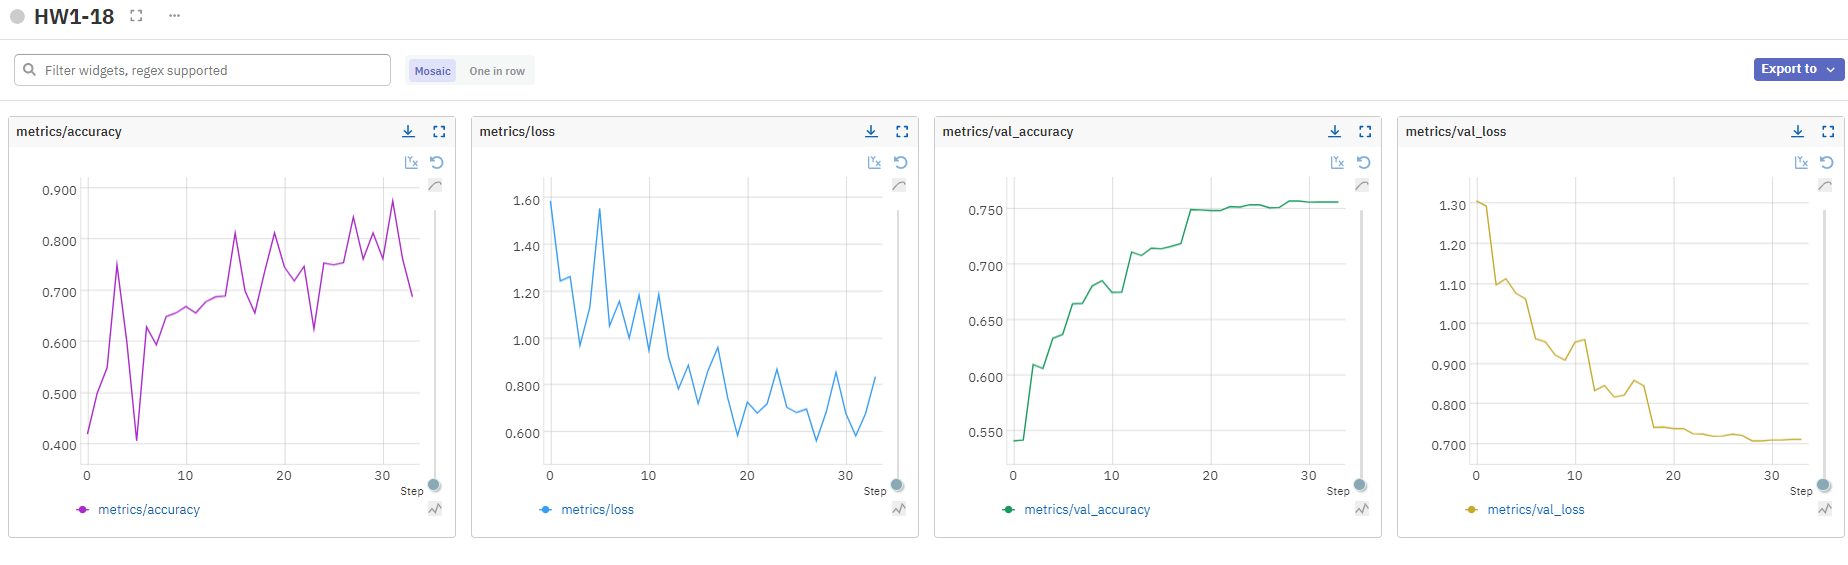

# **Собственный и оптуна**

In [ ]:
def create_model(trial):
    num_filters_1 = trial.suggest_int('num_filters_1', 16, 64)
    num_filters_2 = trial.suggest_int('num_filters_2', 32, 128)
    num_filters_3 = trial.suggest_int('num_filters_3', 32, 128)
    dense_units = trial.suggest_int('dense_units', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential([
        Input(shape=(32, 32, 3)),
        Conv2D(num_filters_1, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(num_filters_2, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(num_filters_3, (3, 3), activation='relu'),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model, learning_rate

def objective(trial):
    model, learning_rate = create_model(trial)

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)
    best_model_path = "best_model_opt_my.keras"
    checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    history = model.fit(custom_generator(train_images, train_labels, batch_size=32),
                        steps_per_epoch=int(len(train_images) / 32),
                        epochs=20,
                        validation_data=(test_images, test_labels),
                        callbacks=[early_stopping, reduce_lr, checkpoint_callback],
                        verbose=0)

    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

best_params = study.best_trial.params
print(f"Лучшие параметры: {best_params}")


[I 2024-07-07 20:16:21,978] A new study created in memory with name: no-name-43c637e9-e50a-41b0-8cbb-d4e196e7d7e6



Epoch 1: val_accuracy improved from -inf to 0.50170, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.50170 to 0.56300, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.56300 to 0.63610, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy did not improve from 0.63610

Epoch 5: val_accuracy improved from 0.63610 to 0.64810, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy did not improve from 0.64810

Epoch 7: val_accuracy improved from 0.64810 to 0.69020, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy improved from 0.69020 to 0.71180, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy did not improve from 0.71180

Epoch 10: val_accuracy did not improve from 0.71180

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 11: val_accuracy did not improve from 0.71180

Epoch 12: val_accuracy improved from 0.71180 to 0.73240, saving model to best_m

[I 2024-07-07 20:28:14,549] Trial 0 finished with value: 0.7541000247001648 and parameters: {'num_filters_1': 55, 'num_filters_2': 107, 'num_filters_3': 103, 'dense_units': 245, 'learning_rate': 4.3181294392459024e-05}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.49790, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.49790 to 0.53030, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.53030 to 0.57110, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy did not improve from 0.57110

Epoch 5: val_accuracy improved from 0.57110 to 0.60180, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.60180 to 0.60950, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy did not improve from 0.60950

Epoch 8: val_accuracy improved from 0.60950 to 0.65540, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy did not improve from 0.65540

Epoch 10: val_accuracy did not improve from 0.65540

Epoch 11: val_accuracy did not improve from 0.65540

Epoch 12: val_accuracy did not improve from 0.65540

Epoch 13: val_accuracy improved from 0.65540 to 0.67330, saving model to best_model_opt_my.keras

Epoch 1

[I 2024-07-07 20:36:26,167] Trial 1 finished with value: 0.6674000024795532 and parameters: {'num_filters_1': 40, 'num_filters_2': 57, 'num_filters_3': 34, 'dense_units': 70, 'learning_rate': 0.00015067934638775068}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.44380, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.44380 to 0.47660, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.47660 to 0.54270, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.54270 to 0.58640, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy did not improve from 0.58640

Epoch 6: val_accuracy did not improve from 0.58640

Epoch 7: val_accuracy improved from 0.58640 to 0.62400, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy did not improve from 0.62400

Epoch 9: val_accuracy improved from 0.62400 to 0.63200, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy did not improve from 0.63200

Epoch 11: val_accuracy improved from 0.63200 to 0.63620, saving model to best_model_opt_my.keras

Epoch 12: val_accuracy did not improve from 0.63620

Epoch 13: val_accuracy did not improve from 0.63620

Epoch 1

[I 2024-07-07 20:44:24,277] Trial 2 finished with value: 0.6797000169754028 and parameters: {'num_filters_1': 19, 'num_filters_2': 110, 'num_filters_3': 35, 'dense_units': 193, 'learning_rate': 0.00043928013854556197}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.45950, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.45950 to 0.54730, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.54730 to 0.57040, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.57040 to 0.59500, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.59500 to 0.63550, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.63550 to 0.66050, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy did not improve from 0.66050

Epoch 8: val_accuracy improved from 0.66050 to 0.67600, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy did not improve from 0.67600

Epoch 10: val_accuracy improved from 0.67600 to 0.68030, saving model to best_model_opt_my.keras

Epoch 11: val_accuracy did not improve from 0.68030

Epoch 12: val_accuracy improved from 0.68030 to 0.68980, saving mode

[I 2024-07-07 20:53:02,498] Trial 3 finished with value: 0.7294999957084656 and parameters: {'num_filters_1': 32, 'num_filters_2': 118, 'num_filters_3': 38, 'dense_units': 48, 'learning_rate': 4.9286778307007075e-05}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.45760, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.45760 to 0.55990, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.55990 to 0.57610, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy did not improve from 0.57610

Epoch 5: val_accuracy improved from 0.57610 to 0.59010, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.59010 to 0.63060, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy did not improve from 0.63060

Epoch 8: val_accuracy improved from 0.63060 to 0.64770, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy did not improve from 0.64770

Epoch 10: val_accuracy improved from 0.64770 to 0.65730, saving model to best_model_opt_my.keras

Epoch 11: val_accuracy did not improve from 0.65730

Epoch 12: val_accuracy improved from 0.65730 to 0.66530, saving model to best_model_opt_my.keras

Epoch 13: val_a

[I 2024-07-07 21:02:31,673] Trial 4 finished with value: 0.6913999915122986 and parameters: {'num_filters_1': 59, 'num_filters_2': 62, 'num_filters_3': 80, 'dense_units': 42, 'learning_rate': 3.9019412506557585e-05}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.53830, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.53830 to 0.59150, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.59150 to 0.63490, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.63490 to 0.65000, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.65000 to 0.65480, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.65480 to 0.69200, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy did not improve from 0.69200

Epoch 8: val_accuracy improved from 0.69200 to 0.69560, saving model to best_model_opt_my.keras

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 9: val_accuracy did not improve from 0.69560

Epoch 10: val_accuracy improved from 0.69560 to 0.73000, saving model to best_model_opt_my.keras

Epoch 11: val_accuracy did not improve from

[I 2024-07-07 21:10:49,234] Trial 5 finished with value: 0.7455999851226807 and parameters: {'num_filters_1': 25, 'num_filters_2': 95, 'num_filters_3': 70, 'dense_units': 110, 'learning_rate': 2.3987171055896816e-05}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.42040, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.42040 to 0.42940, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.42940 to 0.52760, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.52760 to 0.53340, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.53340 to 0.56710, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy did not improve from 0.56710

Epoch 7: val_accuracy improved from 0.56710 to 0.58080, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy improved from 0.58080 to 0.58660, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy did not improve from 0.58660

Epoch 10: val_accuracy improved from 0.58660 to 0.62130, saving model to best_model_opt_my.keras

Epoch 11: val_accuracy improved from 0.62130 to 0.62150, saving model to best_model_opt_my.keras

Epoch 12: val_accuracy 

[I 2024-07-07 21:21:50,117] Trial 6 finished with value: 0.6521999835968018 and parameters: {'num_filters_1': 64, 'num_filters_2': 92, 'num_filters_3': 96, 'dense_units': 133, 'learning_rate': 0.0030006272575645336}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.38530, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.38530 to 0.46350, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.46350 to 0.47900, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.47900 to 0.53270, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.53270 to 0.53490, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.53490 to 0.55790, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy improved from 0.55790 to 0.56690, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy improved from 0.56690 to 0.58090, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy improved from 0.58090 to 0.58870, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy improved from 0.58870 to 0.59620, saving model to best_model_opt_my.keras

Epoch 11: val_accuracy improved

[I 2024-07-07 21:30:08,758] Trial 7 finished with value: 0.6714000105857849 and parameters: {'num_filters_1': 34, 'num_filters_2': 34, 'num_filters_3': 84, 'dense_units': 225, 'learning_rate': 1.118255591515397e-05}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.50100, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.50100 to 0.55250, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy did not improve from 0.55250

Epoch 4: val_accuracy improved from 0.55250 to 0.59220, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.59220 to 0.61520, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.61520 to 0.64510, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy improved from 0.64510 to 0.65900, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy did not improve from 0.65900

Epoch 9: val_accuracy improved from 0.65900 to 0.67470, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy did not improve from 0.67470

Epoch 11: val_accuracy did not improve from 0.67470

Epoch 12: val_accuracy improved from 0.67470 to 0.69600, saving model to best_model_opt_my.keras

Epoch 13: val_a

[I 2024-07-07 21:41:01,637] Trial 8 finished with value: 0.72079998254776 and parameters: {'num_filters_1': 44, 'num_filters_2': 119, 'num_filters_3': 56, 'dense_units': 69, 'learning_rate': 0.0036515014444509085}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.38150, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.38150 to 0.48440, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.48440 to 0.54270, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy did not improve from 0.54270

Epoch 5: val_accuracy improved from 0.54270 to 0.57130, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.57130 to 0.59010, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy did not improve from 0.59010

Epoch 8: val_accuracy did not improve from 0.59010

Epoch 9: val_accuracy improved from 0.59010 to 0.61950, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy did not improve from 0.61950

Epoch 11: val_accuracy did not improve from 0.61950

Epoch 12: val_accuracy improved from 0.61950 to 0.62920, saving model to best_model_opt_my.keras

Epoch 13: val_accuracy did not improve from 0.62920

Epoch 1

[I 2024-07-07 21:49:25,969] Trial 9 finished with value: 0.6787999868392944 and parameters: {'num_filters_1': 21, 'num_filters_2': 105, 'num_filters_3': 81, 'dense_units': 54, 'learning_rate': 0.002963137015580919}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.44380, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.44380 to 0.45020, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.45020 to 0.52820, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.52820 to 0.53660, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.53660 to 0.61770, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.61770 to 0.62410, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy did not improve from 0.62410

Epoch 8: val_accuracy improved from 0.62410 to 0.63610, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy improved from 0.63610 to 0.65080, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy did not improve from 0.65080

Epoch 11: val_accuracy improved from 0.65080 to 0.66210, saving model to best_model_opt_my.keras

Epoch 12: val_accuracy 

[I 2024-07-07 22:00:13,353] Trial 10 finished with value: 0.6682999730110168 and parameters: {'num_filters_1': 50, 'num_filters_2': 75, 'num_filters_3': 127, 'dense_units': 235, 'learning_rate': 0.0005020566971377251}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.44920, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.44920 to 0.52850, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.52850 to 0.56280, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.56280 to 0.56360, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.56360 to 0.61710, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy did not improve from 0.61710

Epoch 7: val_accuracy improved from 0.61710 to 0.63700, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy did not improve from 0.63700

Epoch 9: val_accuracy improved from 0.63700 to 0.66570, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy did not improve from 0.66570

Epoch 11: val_accuracy did not improve from 0.66570

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 12: val_accuracy improved fr

[I 2024-07-07 22:11:21,581] Trial 11 finished with value: 0.717199981212616 and parameters: {'num_filters_1': 54, 'num_filters_2': 93, 'num_filters_3': 114, 'dense_units': 129, 'learning_rate': 1.308138056864509e-05}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.42140, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.42140 to 0.51170, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.51170 to 0.57430, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.57430 to 0.62130, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy did not improve from 0.62130

Epoch 6: val_accuracy improved from 0.62130 to 0.63320, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy improved from 0.63320 to 0.63790, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy did not improve from 0.63790

Epoch 9: val_accuracy improved from 0.63790 to 0.65580, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy did not improve from 0.65580

Epoch 11: val_accuracy improved from 0.65580 to 0.67560, saving model to best_model_opt_my.keras

Epoch 12: val_accuracy improved from 0.67560 to 0.67890, saving mode

[I 2024-07-07 22:20:25,985] Trial 12 finished with value: 0.7386000156402588 and parameters: {'num_filters_1': 28, 'num_filters_2': 128, 'num_filters_3': 63, 'dense_units': 189, 'learning_rate': 6.868923377254816e-05}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.41270, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.41270 to 0.46920, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.46920 to 0.49750, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.49750 to 0.53530, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.53530 to 0.53720, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.53720 to 0.55490, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy improved from 0.55490 to 0.55650, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy did not improve from 0.55650

Epoch 9: val_accuracy improved from 0.55650 to 0.59890, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy did not improve from 0.59890

Epoch 11: val_accuracy improved from 0.59890 to 0.60250, saving model to best_model_opt_my.keras

Epoch 12: val_accuracy 

[I 2024-07-07 22:30:48,268] Trial 13 finished with value: 0.6453999876976013 and parameters: {'num_filters_1': 47, 'num_filters_2': 93, 'num_filters_3': 104, 'dense_units': 104, 'learning_rate': 2.302258369899163e-05}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.45320, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy did not improve from 0.45320

Epoch 3: val_accuracy improved from 0.45320 to 0.51790, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.51790 to 0.55790, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.55790 to 0.58120, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy did not improve from 0.58120

Epoch 7: val_accuracy improved from 0.58120 to 0.58140, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy did not improve from 0.58140

Epoch 9: val_accuracy improved from 0.58140 to 0.60740, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy did not improve from 0.60740

Epoch 11: val_accuracy improved from 0.60740 to 0.63710, saving model to best_model_opt_my.keras

Epoch 12: val_accuracy did not improve from 0.63710

Epoch 13: val_accuracy improved from 0.63710 to 0.64650, sav

[I 2024-07-07 22:39:05,326] Trial 14 finished with value: 0.6686999797821045 and parameters: {'num_filters_1': 25, 'num_filters_2': 81, 'num_filters_3': 63, 'dense_units': 166, 'learning_rate': 0.0001243024007466809}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.49910, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.49910 to 0.54870, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.54870 to 0.58870, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.58870 to 0.60210, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.60210 to 0.62730, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy did not improve from 0.62730

Epoch 7: val_accuracy improved from 0.62730 to 0.62770, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy improved from 0.62770 to 0.63410, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy improved from 0.63410 to 0.64850, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy did not improve from 0.64850

Epoch 11: val_accuracy improved from 0.64850 to 0.67230, saving model to best_model_opt_my.keras

Epoch 12: val_accuracy 

[I 2024-07-07 22:48:14,562] Trial 15 finished with value: 0.7217000126838684 and parameters: {'num_filters_1': 34, 'num_filters_2': 105, 'num_filters_3': 95, 'dense_units': 100, 'learning_rate': 0.000942937338401302}. Best is trial 0 with value: 0.7541000247001648.



Epoch 1: val_accuracy improved from -inf to 0.51110, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.51110 to 0.58990, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.58990 to 0.62980, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.62980 to 0.65560, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.65560 to 0.66160, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.66160 to 0.68850, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy improved from 0.68850 to 0.70780, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy did not improve from 0.70780

Epoch 9: val_accuracy did not improve from 0.70780

Epoch 10: val_accuracy improved from 0.70780 to 0.72040, saving model to best_model_opt_my.keras

Epoch 11: val_accuracy improved from 0.72040 to 0.72140, saving model to best_model_opt_my.keras

Epoch 12: val_accuracy 

[I 2024-07-07 22:56:54,147] Trial 16 finished with value: 0.7609000205993652 and parameters: {'num_filters_1': 16, 'num_filters_2': 80, 'num_filters_3': 115, 'dense_units': 247, 'learning_rate': 0.00014621957133429238}. Best is trial 16 with value: 0.7609000205993652.



Epoch 1: val_accuracy improved from -inf to 0.45980, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.45980 to 0.51300, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.51300 to 0.57770, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.57770 to 0.60150, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy did not improve from 0.60150

Epoch 6: val_accuracy improved from 0.60150 to 0.62030, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy improved from 0.62030 to 0.62650, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy improved from 0.62650 to 0.63340, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy improved from 0.63340 to 0.63900, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy improved from 0.63900 to 0.67130, saving model to best_model_opt_my.keras

Epoch 11: val_accuracy did not improve from 0.67130

Epoch 12: val_accuracy 

[I 2024-07-07 23:05:37,453] Trial 17 finished with value: 0.7089999914169312 and parameters: {'num_filters_1': 16, 'num_filters_2': 73, 'num_filters_3': 128, 'dense_units': 251, 'learning_rate': 0.0001983805116760562}. Best is trial 16 with value: 0.7609000205993652.



Epoch 1: val_accuracy improved from -inf to 0.42550, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.42550 to 0.51250, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.51250 to 0.54410, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.54410 to 0.57740, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy did not improve from 0.57740

Epoch 6: val_accuracy improved from 0.57740 to 0.61860, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy did not improve from 0.61860

Epoch 8: val_accuracy improved from 0.61860 to 0.62280, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy improved from 0.62280 to 0.64140, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy improved from 0.64140 to 0.66600, saving model to best_model_opt_my.keras

Epoch 11: val_accuracy did not improve from 0.66600

Epoch 12: val_accuracy improved from 0.66600 to 0.66650, saving mode

[I 2024-07-07 23:15:32,400] Trial 18 finished with value: 0.7105000019073486 and parameters: {'num_filters_1': 39, 'num_filters_2': 47, 'num_filters_3': 114, 'dense_units': 209, 'learning_rate': 0.008867554023056045}. Best is trial 16 with value: 0.7609000205993652.



Epoch 1: val_accuracy improved from -inf to 0.53230, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.53230 to 0.61090, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy did not improve from 0.61090

Epoch 4: val_accuracy improved from 0.61090 to 0.67510, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.67510 to 0.68090, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.68090 to 0.70030, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy did not improve from 0.70030

Epoch 8: val_accuracy did not improve from 0.70030

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 9: val_accuracy improved from 0.70030 to 0.70580, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy improved from 0.70580 to 0.73020, saving model to best_model_opt_my.keras

Epoch 11: val_accuracy improved from 0.73020 to 0.73190, saving model to best_model_opt_

[I 2024-07-07 23:27:08,044] Trial 19 finished with value: 0.742900013923645 and parameters: {'num_filters_1': 54, 'num_filters_2': 84, 'num_filters_3': 112, 'dense_units': 254, 'learning_rate': 9.797718815126223e-05}. Best is trial 16 with value: 0.7609000205993652.



Epoch 1: val_accuracy improved from -inf to 0.46630, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.46630 to 0.51760, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.51760 to 0.60580, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.60580 to 0.62350, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy did not improve from 0.62350

Epoch 6: val_accuracy improved from 0.62350 to 0.63180, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy improved from 0.63180 to 0.63860, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy improved from 0.63860 to 0.66890, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy improved from 0.66890 to 0.67660, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy improved from 0.67660 to 0.68370, saving model to best_model_opt_my.keras

Epoch 11: val_accuracy did not improve from 0.68370

Epoch 12: val_accuracy 

[I 2024-07-07 23:38:14,317] Trial 20 finished with value: 0.7354999780654907 and parameters: {'num_filters_1': 64, 'num_filters_2': 65, 'num_filters_3': 95, 'dense_units': 167, 'learning_rate': 0.0009708901970892496}. Best is trial 16 with value: 0.7609000205993652.



Epoch 1: val_accuracy improved from -inf to 0.38530, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.38530 to 0.52050, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy did not improve from 0.52050

Epoch 4: val_accuracy improved from 0.52050 to 0.56790, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.56790 to 0.58810, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.58810 to 0.60400, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy improved from 0.60400 to 0.61760, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy improved from 0.61760 to 0.63300, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy improved from 0.63300 to 0.63850, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy improved from 0.63850 to 0.63970, saving model to best_model_opt_my.keras

Epoch 11: val_accuracy improved from 0.63970 to 0.65490, saving model to bes

[I 2024-07-07 23:46:37,020] Trial 21 finished with value: 0.694599986076355 and parameters: {'num_filters_1': 23, 'num_filters_2': 100, 'num_filters_3': 71, 'dense_units': 101, 'learning_rate': 2.608423388111607e-05}. Best is trial 16 with value: 0.7609000205993652.



Epoch 1: val_accuracy improved from -inf to 0.46810, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.46810 to 0.56720, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.56720 to 0.59530, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.59530 to 0.61020, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy did not improve from 0.61020

Epoch 6: val_accuracy improved from 0.61020 to 0.64270, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy improved from 0.64270 to 0.65210, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy improved from 0.65210 to 0.65310, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy improved from 0.65310 to 0.68600, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy did not improve from 0.68600

Epoch 11: val_accuracy improved from 0.68600 to 0.69220, saving model to best_model_opt_my.keras

Epoch 12: val_accuracy 

[I 2024-07-07 23:54:12,615] Trial 22 finished with value: 0.7324000000953674 and parameters: {'num_filters_1': 16, 'num_filters_2': 87, 'num_filters_3': 49, 'dense_units': 225, 'learning_rate': 2.207394119378818e-05}. Best is trial 16 with value: 0.7609000205993652.



Epoch 1: val_accuracy improved from -inf to 0.46280, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.46280 to 0.54670, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.54670 to 0.56710, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.56710 to 0.58790, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.58790 to 0.62460, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.62460 to 0.62920, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy improved from 0.62920 to 0.65230, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy improved from 0.65230 to 0.67840, saving model to best_model_opt_my.keras

Epoch 9: val_accuracy did not improve from 0.67840

Epoch 10: val_accuracy did not improve from 0.67840

Epoch 11: val_accuracy improved from 0.67840 to 0.68990, saving model to best_model_opt_my.keras

Epoch 12: val_accuracy 

[I 2024-07-08 00:03:14,204] Trial 23 finished with value: 0.7296000123023987 and parameters: {'num_filters_1': 27, 'num_filters_2': 99, 'num_filters_3': 105, 'dense_units': 158, 'learning_rate': 5.418025063463321e-05}. Best is trial 16 with value: 0.7609000205993652.



Epoch 1: val_accuracy improved from -inf to 0.45200, saving model to best_model_opt_my.keras

Epoch 2: val_accuracy improved from 0.45200 to 0.55050, saving model to best_model_opt_my.keras

Epoch 3: val_accuracy improved from 0.55050 to 0.57200, saving model to best_model_opt_my.keras

Epoch 4: val_accuracy improved from 0.57200 to 0.58930, saving model to best_model_opt_my.keras

Epoch 5: val_accuracy improved from 0.58930 to 0.60250, saving model to best_model_opt_my.keras

Epoch 6: val_accuracy improved from 0.60250 to 0.60680, saving model to best_model_opt_my.keras

Epoch 7: val_accuracy improved from 0.60680 to 0.63480, saving model to best_model_opt_my.keras

Epoch 8: val_accuracy did not improve from 0.63480

Epoch 9: val_accuracy improved from 0.63480 to 0.63840, saving model to best_model_opt_my.keras

Epoch 10: val_accuracy improved from 0.63840 to 0.65270, saving model to best_model_opt_my.keras

Epoch 11: val_accuracy improved from 0.65270 to 0.66960, saving model to bes

[I 2024-07-08 00:11:58,696] Trial 24 finished with value: 0.7213000059127808 and parameters: {'num_filters_1': 29, 'num_filters_2': 73, 'num_filters_3': 88, 'dense_units': 198, 'learning_rate': 0.00026655923409906466}. Best is trial 16 with value: 0.7609000205993652.


Лучшие параметры: {'num_filters_1': 16, 'num_filters_2': 80, 'num_filters_3': 115, 'dense_units': 247, 'learning_rate': 0.00014621957133429238}


**Лучшие параметры: {'num_filters_1': 16, 'num_filters_2': 80, 'num_filters_3': 115, 'dense_units': 247, 'learning_rate': 0.00014621957133429238}**

**1 попытка**

In [ ]:
model, _ = create_model(study.best_trial)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


run = neptune.init_run(
    project="vladislavermakovich/HW33",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)

neptune_logger = NeptuneLogger()

best_model_path = "best_model_optuna_my.keras"
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(custom_generator(train_images, train_labels, batch_size=32),
          steps_per_epoch=int(len(train_images) / 32),
          epochs=50,
          validation_data=(test_images, test_labels),
          callbacks=[neptune_logger, early_stopping, reduce_lr, checkpoint_callback])

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/HW33/e/HW1-19
Epoch 1/50
1560/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2777 - loss: 1.9227
Epoch 1: val_accuracy improved from -inf to 0.45810, saving model to best_model_optuna_my.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.2778 - loss: 1.9225 - val_accuracy: 0.4581 - val_loss: 1.4563 - learning_rate: 0.0010
Epoch 2/50
1561/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4175 - loss: 1.5866
Epoch 2: val_accuracy improved from 0.45810 to 0.53080, saving model to best_model_optuna_my.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.4175 - loss: 1.5865 - val_accuracy: 0.5308 - val_loss: 1.3100 - learning_rate: 0.0010
Epoch 3/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4818 - loss: 1.4483
Epoch 3: val_accuracy improved from 0.53080 to 0.56160, saving model to best_model_optuna_my.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 30s

0.7037

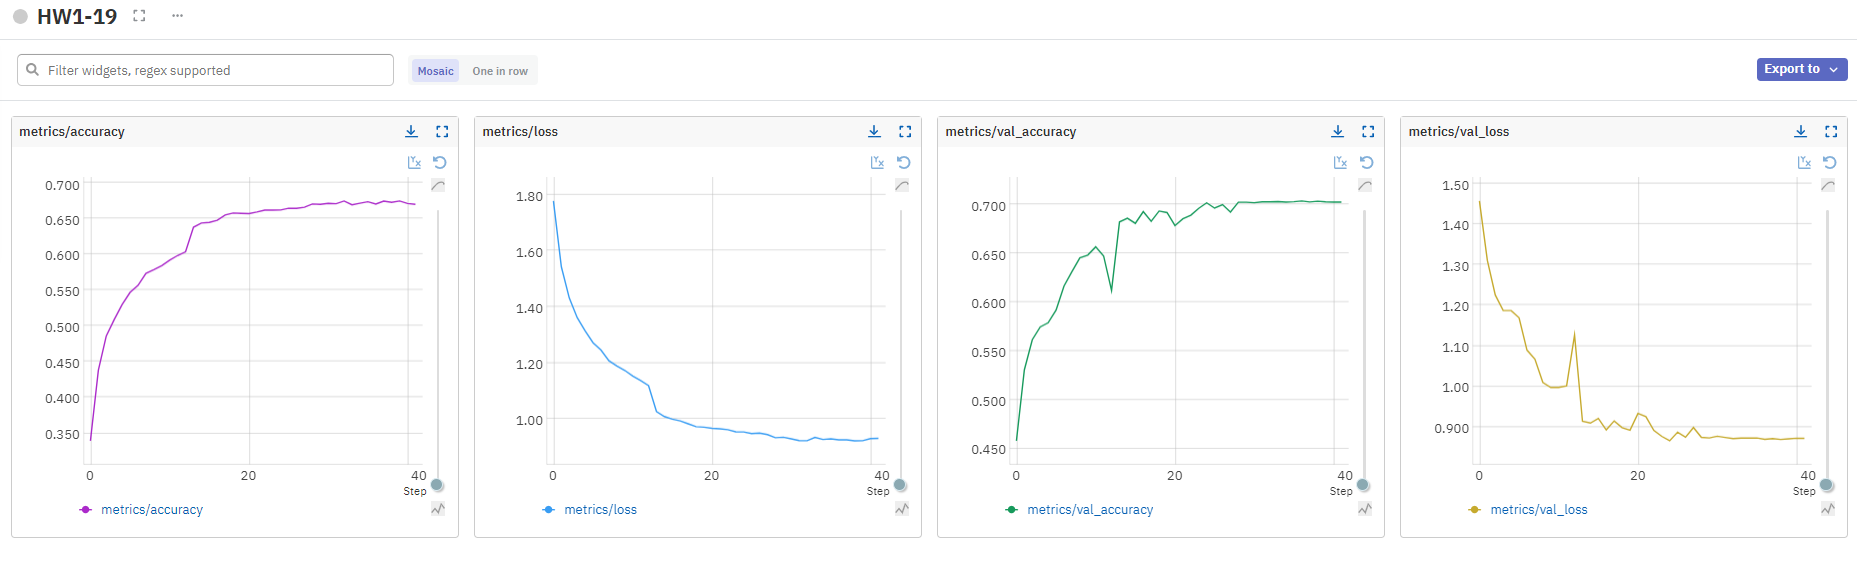

**2 попытка**

In [ ]:
model, _ = create_model(study.best_trial)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


run = neptune.init_run(
    project="vladislavermakovich/HW33",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)

neptune_logger = NeptuneLogger()

best_model_path = "best_model_optuna_my_1.1.keras"
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(custom_generator(train_images, train_labels, batch_size=32),
          steps_per_epoch=int(len(train_images) / 32),
          epochs=50,
          validation_data=(test_images, test_labels),
          callbacks=[neptune_logger, early_stopping, reduce_lr, checkpoint_callback])

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/HW33/e/HW1-20
Epoch 1/50
1560/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2475 - loss: 1.9852
Epoch 1: val_accuracy improved from -inf to 0.39710, saving model to best_model_optuna_my_1.1.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.2476 - loss: 1.9850 - val_accuracy: 0.3971 - val_loss: 1.6342 - learning_rate: 0.0010
Epoch 2/50
1561/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4002 - loss: 1.6304
Epoch 2: val_accuracy improved from 0.39710 to 0.49790, saving model to best_model_optuna_my_1.1.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.4002 - loss: 1.6304 - val_accuracy: 0.4979 - val_loss: 1.3921 - learning_rate: 0.0010
Epoch 3/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4552 - loss: 1.4888
Epoch 3: val_accuracy improved from 0.49790 to 0.55020, saving model to best_model_optuna_my_1.1.keras
1562/1562 ━━━━━━━━━━━━

0.7340

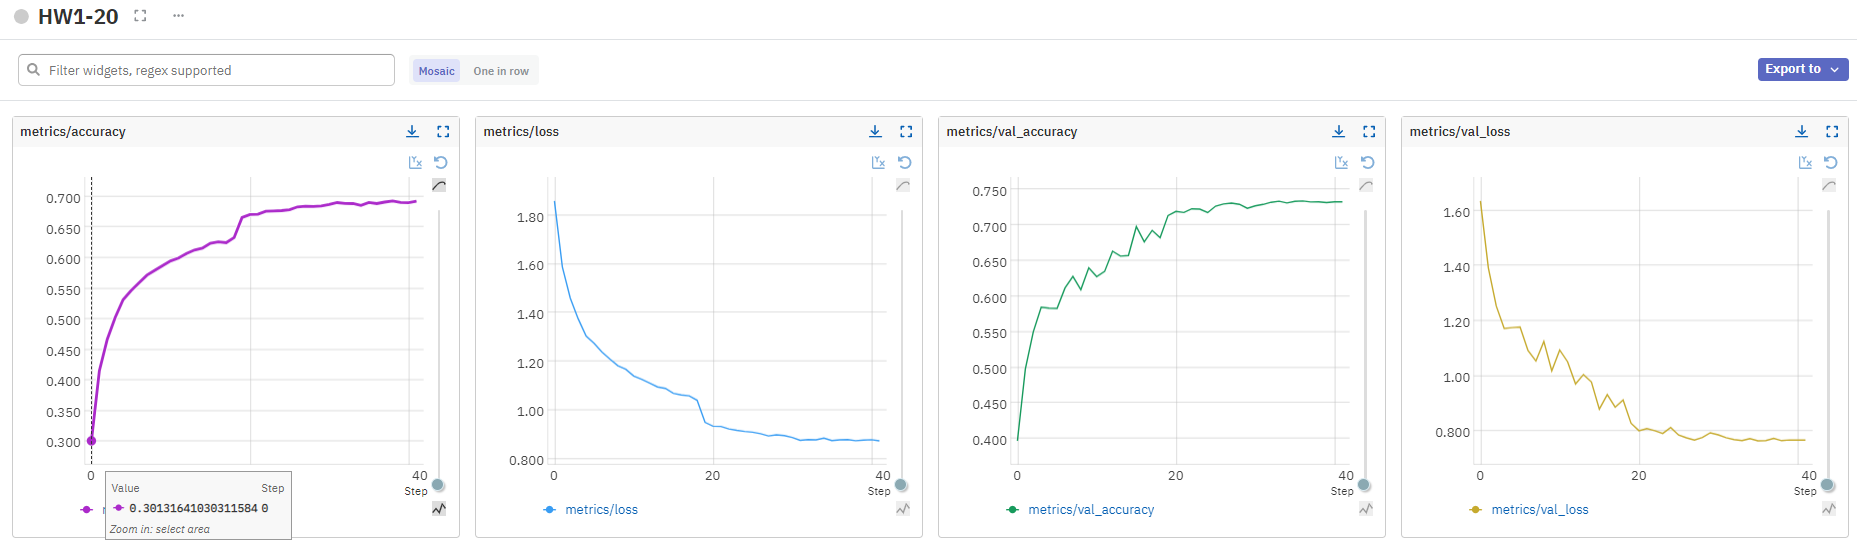

**3 попытка**

In [ ]:
model, _ = create_model(study.best_trial)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


run = neptune.init_run(
    project="vladislavermakovich/HW33",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)

neptune_logger = NeptuneLogger()

best_model_path = "best_model_optuna_my_1.2.keras"
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(custom_generator(train_images, train_labels, batch_size=32),
          steps_per_epoch=int(len(train_images) / 32),
          epochs=50,
          validation_data=(test_images, test_labels),
          callbacks=[neptune_logger, early_stopping, reduce_lr, checkpoint_callback])

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/HW33/e/HW1-21
Epoch 1/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2577 - loss: 1.9664
Epoch 1: val_accuracy improved from -inf to 0.38230, saving model to best_model_optuna_my_1.2.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.2577 - loss: 1.9663 - val_accuracy: 0.3823 - val_loss: 1.6708 - learning_rate: 0.0010
Epoch 2/50
1560/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4056 - loss: 1.6123
Epoch 2: val_accuracy improved from 0.38230 to 0.50590, saving model to best_model_optuna_my_1.2.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.4056 - loss: 1.6123 - val_accuracy: 0.5059 - val_loss: 1.3606 - learning_rate: 0.0010
Epoch 3/50
1560/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4624 - loss: 1.4770
Epoch 3: val_accuracy improved from 0.50590 to 0.52800, saving model to best_model_optuna_my_1.2.keras
1562/1562 ━━━━━━━━━━━━

0.7360

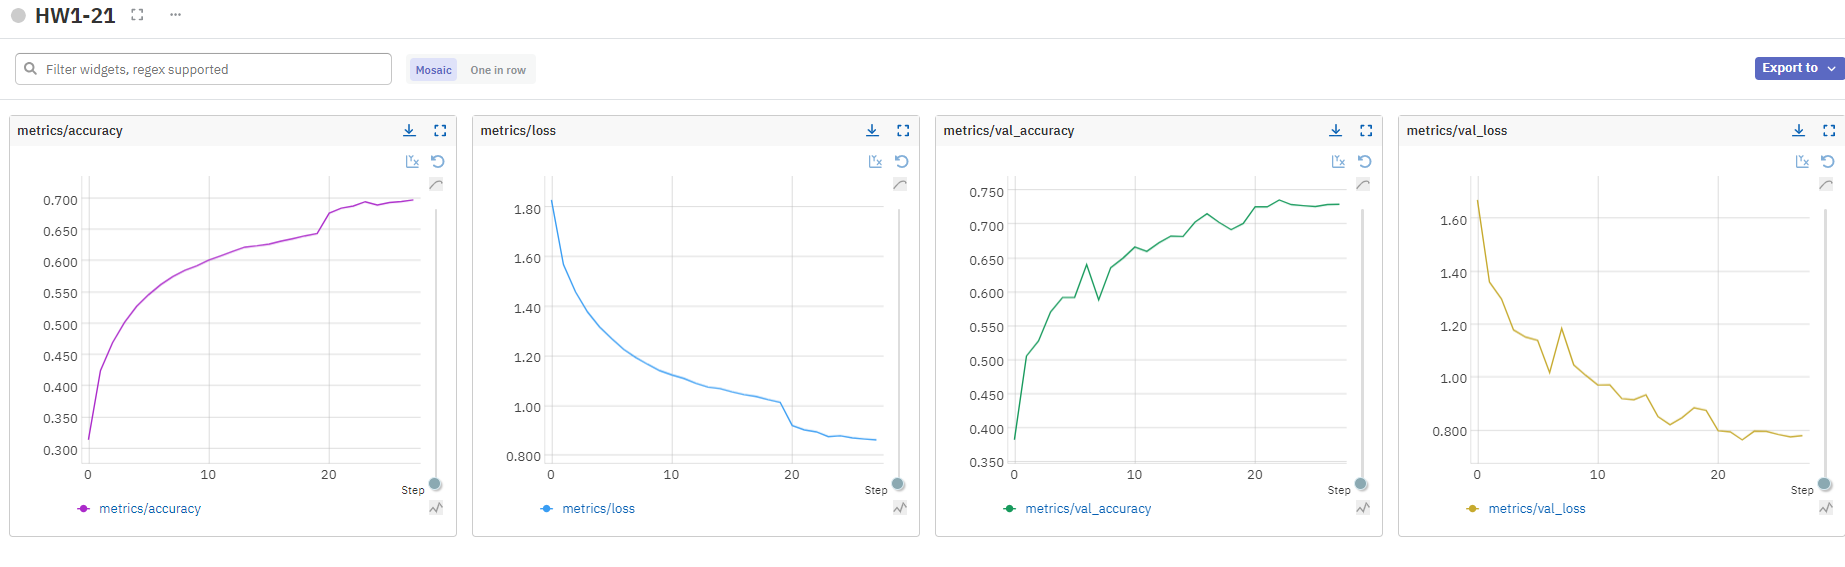

**4 попытка**

In [ ]:
model, _ = create_model(study.best_trial)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


run = neptune.init_run(
    project="vladislavermakovich/HW33",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)

neptune_logger = NeptuneLogger()

best_model_path = "best_model_optuna_my_1.3.keras"
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(custom_generator(train_images, train_labels, batch_size=32),
          steps_per_epoch=int(len(train_images) / 32),
          epochs=50,
          validation_data=(test_images, test_labels),
          callbacks=[neptune_logger, early_stopping, reduce_lr, checkpoint_callback])

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/HW33/e/HW1-22
Epoch 1/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3051 - loss: 1.8602
Epoch 1: val_accuracy improved from -inf to 0.49860, saving model to best_model_optuna_my_1.3.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.3052 - loss: 1.8601 - val_accuracy: 0.4986 - val_loss: 1.3830 - learning_rate: 0.0010
Epoch 2/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4849 - loss: 1.4230
Epoch 2: val_accuracy improved from 0.49860 to 0.59520, saving model to best_model_optuna_my_1.3.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.4849 - loss: 1.4230 - val_accuracy: 0.5952 - val_loss: 1.1265 - learning_rate: 0.0010
Epoch 3/50
1561/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5482 - loss: 1.2604
Epoch 3: val_accuracy improved from 0.59520 to 0.62880, saving model to best_model_optuna_my_1.3.keras
1562/1562 ━━━━━━━━━━━━

0.74150

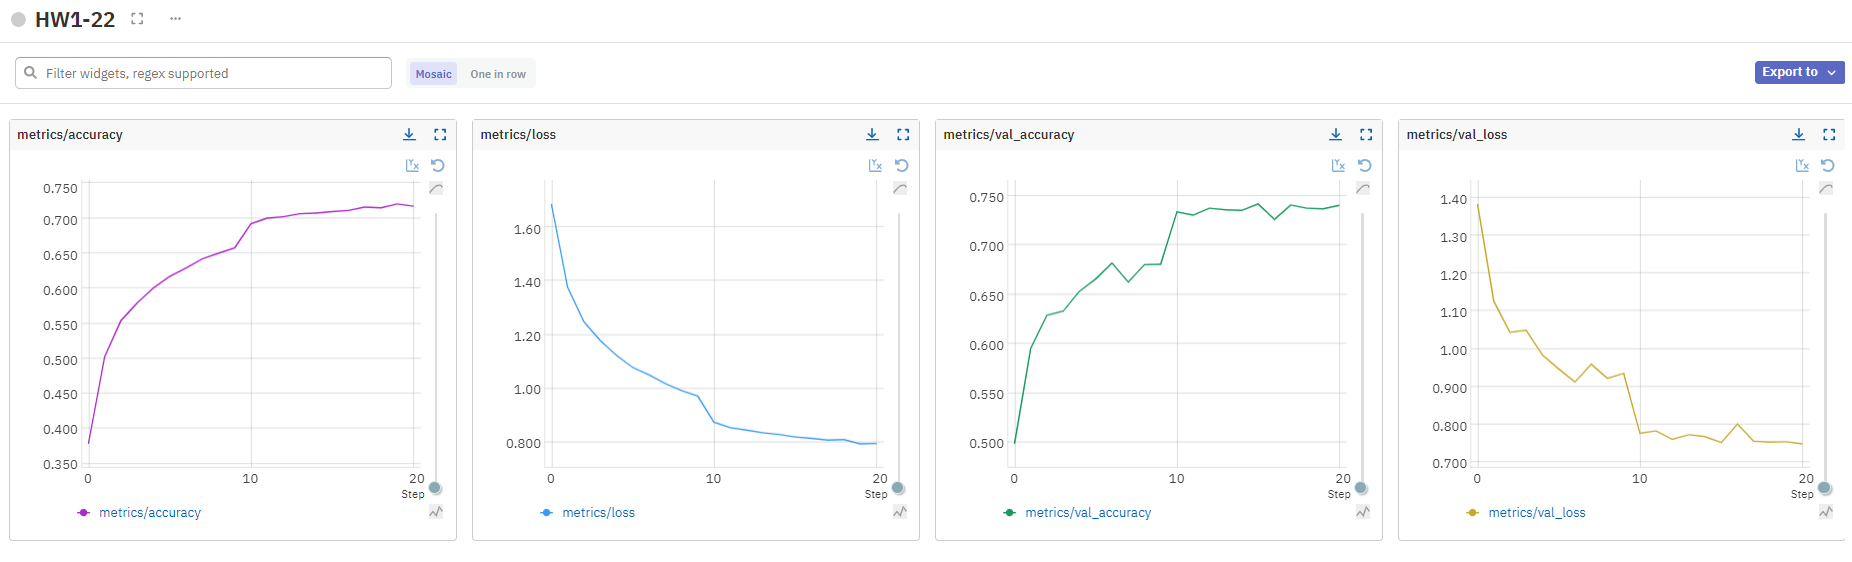

**5 попытка))**

In [ ]:
model, _ = create_model(study.best_trial)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


run = neptune.init_run(
    project="vladislavermakovich/HW33",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)

neptune_logger = NeptuneLogger()

best_model_path = "best_model_optuna_my_1.4.keras"
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(custom_generator(train_images, train_labels, batch_size=32),
          steps_per_epoch=int(len(train_images) / 32),
          epochs=50,
          validation_data=(test_images, test_labels),
          callbacks=[neptune_logger, early_stopping, reduce_lr, checkpoint_callback])

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/HW33/e/HW1-23
Epoch 1/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3014 - loss: 1.8743
Epoch 1: val_accuracy improved from -inf to 0.49890, saving model to best_model_optuna_my_1.4.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.3014 - loss: 1.8742 - val_accuracy: 0.4989 - val_loss: 1.3761 - learning_rate: 0.0010
Epoch 2/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4669 - loss: 1.4654
Epoch 2: val_accuracy improved from 0.49890 to 0.55940, saving model to best_model_optuna_my_1.4.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.4669 - loss: 1.4654 - val_accuracy: 0.5594 - val_loss: 1.2140 - learning_rate: 0.0010
Epoch 3/50
1561/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5123 - loss: 1.3597
Epoch 3: val_accuracy improved from 0.55940 to 0.59150, saving model to best_model_optuna_my_1.4.keras
1562/1562 ━━━━━━━━━━━━

0.71520

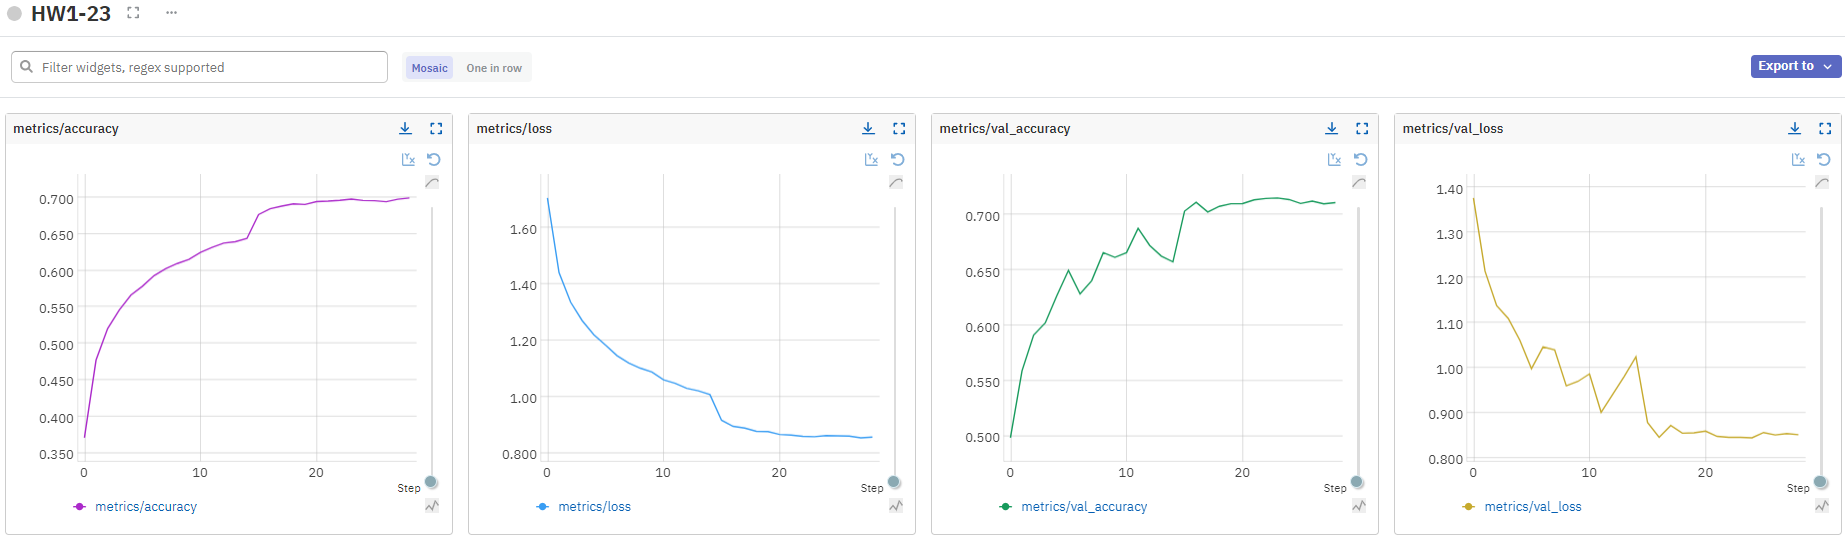

# **Сравнение оптуны датагена с ноутбука и собственного**

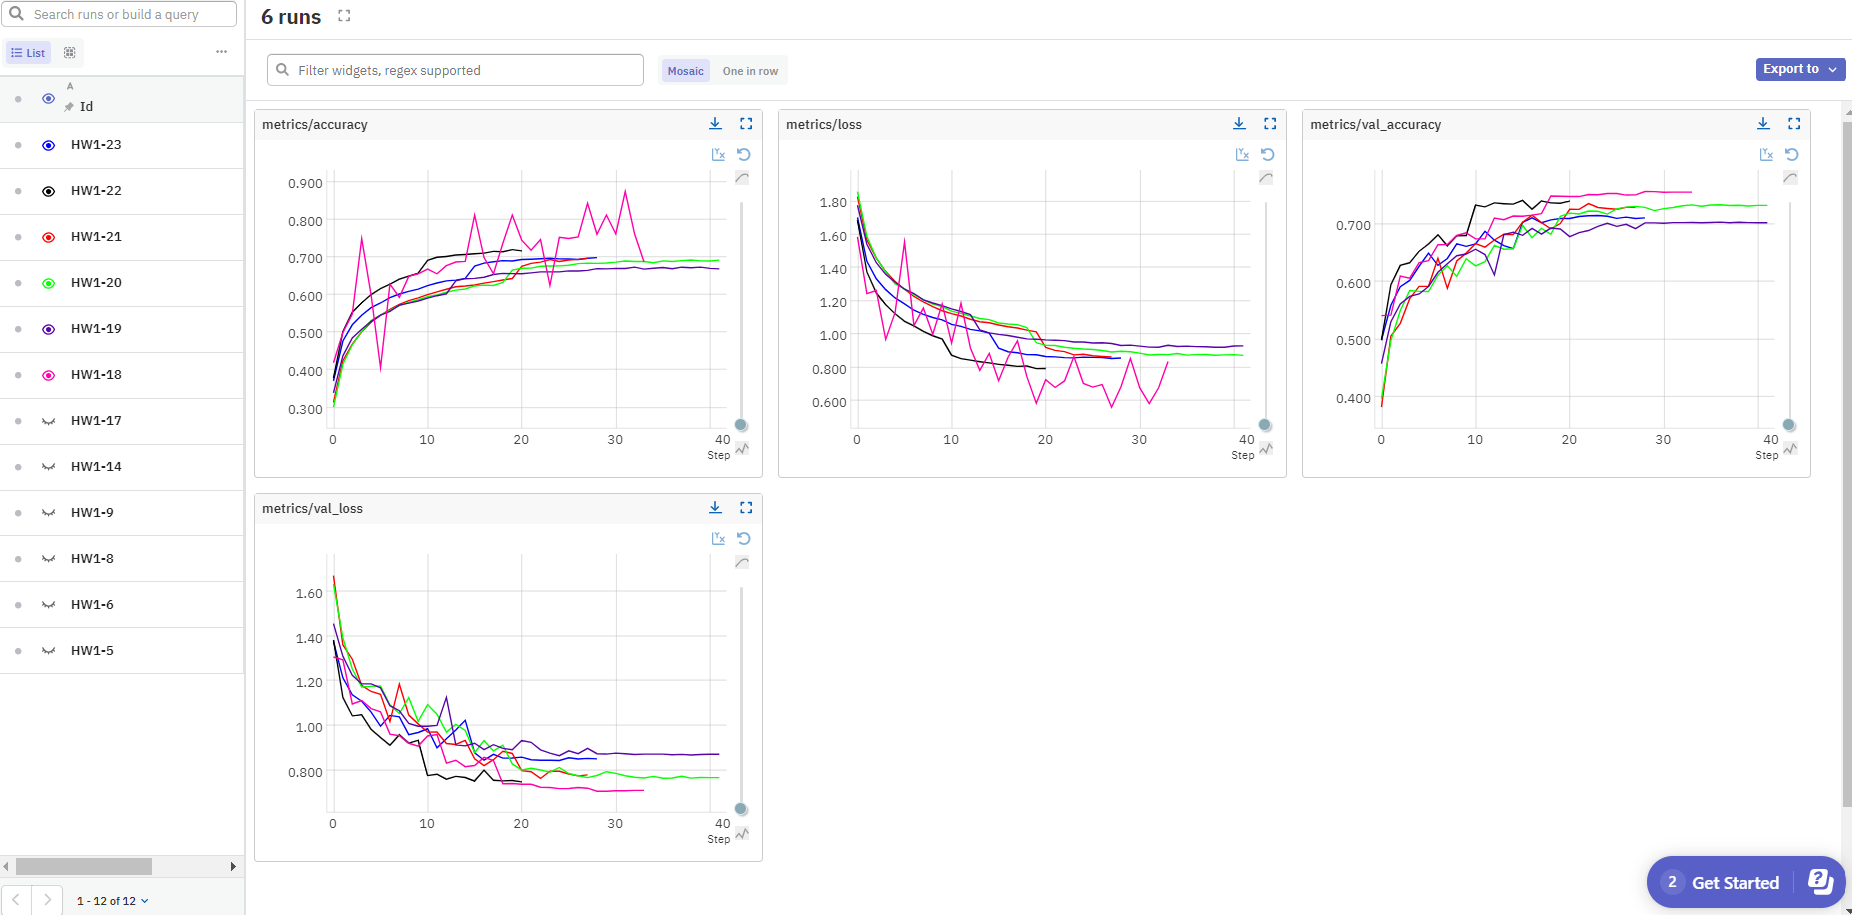

18 - это ноубука

Все остальные - попытки его перепрыгнуть(собственный)

**Вывод:**

**Как я не пытался, но обогнать датаген с ноутбука не вышло. У датагена с ноутбука: 0.7568; у собственного составило: 0.7415**